# CREDIT RISK MODELLING AND DEFAULT DETECTION - DATA SCIENCE APPROACH USING BINARY CLASSIFICATION

# RYZYKO KREDYTOWE I DETEKCJA NIEWYPŁACALNOŚCI: MODELOWANIE ZA POMOCĄ KLASYFIKACJI BINARNEJ

# Summary

**Aim:**
The aim of this project is to build a classification model for bad (default) loans detection. This is based on the Lending Club Loan Data available on Kaggle. For the datasource click [here][1].

[1]: https://www.kaggle.com/wendykan/lending-club-loan-data

As we any loan provider would be much more concerned about failing to notice a client who will default than a rejecting a loan application for a potentially good client, we are more concerned about minimising the **Type II** error and so the **Recall** score, apart from the usual hybrid metrics such as AUC and F1 score.

The main **challenges** of this dataset are:
- The dataset is relatively **large**. When I first started analysing it two months ago, it consisted of 800k data points, however now it is more than 2m. of observations.
- This is a highly **imbalanced**. Only about 1% of data of the original dataset are defaults. This poses a challenge, because, if using all data for making predictions, the model will be inclined to assign all observations to the majority class (non-defaults). This is why the recall metric and the mixed AUC or F1 (instead of simple accuracy) are so crucial here for modelling purposes.
- The dataset contains outside information, i.e. features containing values "conditional" on the default / non-default event happening. Deleting them from the training dataset is crucial as otherwise we would run into data leakage problems.

The dataset consists of more than 2m. entries and 145 variables in its original form. The variables are quite diverse - from numerical values, through simple categorical data to dates and url numbers and identifiers. There is one columns, namely the empl_title, which states the customers employer or position description. I will make use of NLP methods here in order to assess its significance for this particular modelling task.

In general, I will focus on tree-based algorithms such as XGBoost and Random Forest. A good idea for the next project would also be to do and compare results of the GBM and Light GBM models.

**Model choice discussion:**
I have chosen to focus on trees due to their flexibility in handling data. For linear models such as different types of regression, the data would need to be scaled and normalised first (the underlying assumption of regression). In general, socio-economic data tends to rather resemble a lognormal distribution (and so is the case here as well) in its shape and the python (and probably all machine learning in general) do not include an implementation of logistic transformation of data. Although, it could happen that in practice some power transformations would also give good results, for the aforementioned reasons I will just use trees. SVM is rather computationally intensive, hence I will not consider it either.

I will consider different data preprocessing methods, undersampling of the dataset and I will also consider some parameter tuning.

In this project, I also wanted to focus on developing my programming skills, in particular **object-oriented programming** so that I will be able to build comprehensive machine learning pipelines in the future.

** (Potential) next steps **:
- I have highlighted the ideas and plans for further project development in the model as ** TODO **
- Building a comprehensive Machine Learning Pipeline including the preprocessing as well as model trainig and evaluation.
- Feature engineering in order to increase the predictive power of the model (for example assessing the dates, aggregating them by different features (groupby) and seeing if there is any more information that could be extracted from the data that would also decrease the feature / data space and decrease the training time
- Adding a Neural Network model and compare its effectiveness with the applied Random Forest and XGBoost (in general, use other modelling techniques, e.h. Light GBM, Deep Learning methods etc.)


Because of the multitude of datapoints in this datase, the exploratory analysis and a significant part of data pre-processing has been done in Kaggle kernel. The modelling part has been done in usual Jupyter notebook Python environment.


** Conclusions **:
- The main "taking" from this project is that data-preprocessing is crucial. It proves the common machine learning "mantra", i.e." ** garbage-in, garbage-out **" . Although there are some more or less standard methods for data analysis, there are no pre-scribed silver bullet solutions. As a consequence, good understanding of the dataset, tailored approach and domain knowledge are extremely important in a job of a Data Scientist.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

# garbage collector
import gc

# drawing
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# OOP Data Pre-Processing:
from sklearn.base import BaseEstimator, TransformerMixin

# for nlp preprocessing
from nltk.corpus import stopwords
import nltk 

# ML standard package, use for model evaluation
np.random.seed(7)
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# tensorflow
import gensim
import tensorflow as tf
from gensim.models import Word2Vec, KeyedVectors, word2vec
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# sample
import random as rn

# ready pre-trained word embeddings
import multiprocessing
from gensim.models import Word2Vec


# standard ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import scipy.stats as ss

# warnings
from warnings import filterwarnings
filterwarnings("ignore")

#model evaluation
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

 #saving the model
import dill as pickle

# dates preprocessing
import datetime

Using TensorFlow backend.


# All Functions

In order to make the analysis and subsequent code clearer, I will load all the functions used in this projects here at once.

**TODO:** In the next parts of developing this project, I plan to put these into a comprehensive pipeline and subsequently build a classification program / application.

#### Main Pre-Processing, Modelling Functions

In [3]:
def convert2Binary(vec, list_of_positives):
    
    """
    The function converts a vector of various levels into a binary vector, where the specific levels
    to be classified as either 0 or 1 should be passed on by the user
    
    data - a vector of data for which the conversion will be made
    list_of_positives - a list of levels which will be classified as 1; all other will be classified as 0
    """
    vec = vec.apply(lambda x: 1 if x in list_of_positives else 0)
    
    return vec

In [4]:
defaults_list = ["Charged off",
                 "Default", 
                 "Does not meet the credit policy. Status: Charged Off", 
                 "Late (31-120 days)"
                ]

In [5]:
def sampleDataset(df, size, target):
    
    '''
    This function takes all entries for which the loan_status was default and randomly selects some of the data from 
    the target variable for which the value is one (the minority class), 
    depending on the specified size of the dataset.
    
    This is because the concentration of the defaults is very small and the number of all entries is more
    than 2m, which would significantly increase training time.
    '''
    
    no_zeros = size - np.sum(df[target]==1)
    df = pd.concat([df.loc[list(np.random.choice(np.sum(df[target]==0), size = no_zeros, replace = False)), :],
                df[df[target]==1]], axis = 0)
    
    return df

In [6]:
def Undersampling(data, target = 'loan_status'):
    '''
    performs undersamping for analysis of empl-title variable for this particular task
    
    '''
    
    ind_rows = rn.sample(list(data[data["loan_status"]==0].index),len(data[data["loan_status"]==1]))
    return pd.concat([pd.DataFrame(data.loc[ind_rows]),data[data["loan_status"]==1]], axis = 0)

In [7]:
class MissingColNames(BaseEstimator, TransformerMixin):
    
    """
    Returns column names for which there are missing values above a given threshold
    """
    
    def __init__(self, threshold): 
        self.threshold = threshold
            
    def fit(self, X, y = None):
        # tutaj metoda fit powinna liczyc procenty (operacja na danych)
        self.missing_percentages = pd.DataFrame(X).isnull().mean(0).values
        self.columns_to_drop = self.missing_percentages > self.threshold/100
        
        return self

    def print_list(self, X):
        X_new = pd.DataFrame(X).copy()
        
        return X_new.iloc[:,self.columns_to_drop].columns.tolist()

* Note: The below "UniqueReport" function is no longer needed for this dataset. When starting the analysis the features such as *url*, *member_id*, etc. contained values. Now they seem to be deleted, however, I will keep this function anyway in my analysis as id data is often present in the dataset and the using the function does not spoil anything here.

In [8]:
def UniqueReport(data):
    '''
    returns the names of columns for which there are unique values
    
    
    Note: The below "UniqueReport" function is no longer needed for this dataset. 
    When starting the analysis the features such as *url*, *member_id*, etc. contained values. 
    Now they seem to be deleted, however, 
    I will keep this function anyway in my analysis as id data is often present in the dataset
    and the using the function does not spoil anything here.
    
    '''
    mylist=[]
    for c in data.columns:
        if len(data[c].value_counts()) == data.shape[0]:
            mylist.append(c)
    return mylist

In [9]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    
    def __init__(self, columns_to_drop):       # tworzymy 
        self.columns_to_drop = columns_to_drop # zapisujemy
            
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        return X_new.drop(self.columns_to_drop, axis = 1, inplace = False)

In [10]:
class Val2OneHot(BaseEstimator, TransformerMixin):
    
    """
    Returns column names for which the number of levels is 2
    """
    
    def __init__(self): 
        self.no_levels = 2
        self.list_vc = []
            
    def fit(self, X, y = None):
        for i in X.columns:
            if len(X[i].unique()) == self.no_levels:
                self.list_vc.append(i)
        return self

    def print_list(self, X):
        X_new = pd.DataFrame(X).copy()
        for j in self.list_vc:
            df[j].replace({df[j].unique()[0]:0, df[j].unique()[1]:1},inplace = True)
        return X_new

#### Functions below are functions applicable to this particular dataset only, these have little usefulness for more general data science projects; I will call them helper functions because they just assisst my analysis

In [11]:
def Plot_Counts_loanStatus(df):
    
    '''
    helper function - plots the countplot, wrapped up in the function only to make the final preprocessing code clearer
    
    '''
    plt.figure(figsize=(14,6))

    loan_status = df["loan_status"].value_counts()
    loan_status_plot = sn.countplot(x='loan_status', data=df,order=loan_status.index)
    loan_status_plot.set_title("Loan Status Counts ", fontsize=25)
    loan_status_plot.set_xlabel("Status", fontsize=15)
    loan_status_plot.set_ylabel("Count", fontsize=15)
    loan_status_plot.set_xticklabels(loan_status.index,rotation=45)
    plt.show()

In [12]:
def CurrentAnalyser(df, current = "Current"):
    
    '''
    This function is also applicable to this dataset only, a helper function
    '''

    df_select = df[["loan_status","issue_d", "term", "last_pymnt_d"]]
    df_select = df_select[df_select.loan_status== current]
    
    # extract number of months in a form of a numerical value from the term feature

    df_select['term_y'] = df_select["term"].apply(lambda x: int(x.strip()[:2])/12)
    df_select = df_select.drop(["term"], axis = 1)

    # split issue date into month and year separately

    new = df_select["issue_d"].str.split("-", n = 1, expand = True)
    df_select["issue_month"]= new[0]
    df_select["issue_year"] = new[1]

    # add term to issue year

    df_select['issue_year'] = df_select["issue_year"].apply(lambda x: int(x))
    df_select['term_y'] = df_select["term_y"].apply(lambda x: int(x))
    df_select["maturity_year"] = df_select["issue_year"]
    df_select["maturity_year"] = df_select["issue_year"] + df_select['term_y']

    # derive maturity date

    df_select['maturity_year'] = df_select["maturity_year"].apply(lambda x: str(x))
    df_select['maturity_d'] = df_select['issue_month'] + '-' + df_select['maturity_year']

    df_select = df_select.drop(["issue_month", "maturity_year", "term_y", "issue_year"], axis = 1)

    # convert to dates format

    df_select["last_pymnt_d"] = df_select["last_pymnt_d"].apply(lambda x: datetime.datetime.strptime(x,'%b-%Y'))
    df_select["maturity_d"] = df_select["maturity_d"].apply(lambda x: datetime.datetime.strptime(x,'%b-%Y'))
    
    return df_select

In [13]:
def Loan_statusCurrent_Replacer(df_select, cutoff_date = '2019-01-01'):
    
    '''
    This function is purely specific for the dataset. In particular, it analyses the "Current" status of the target variable,
    and this analysis will most likely be applicable to this particular dataset or a another PD model with very similar
    target variable characteristics.
    
    '''
    
    df_select["pmt_comparison"] = df_select["last_pymnt_d"] == df_select["maturity_d"]
    fully_paid_idx = df_select[df_select["pmt_comparison"] == True].index.tolist()
    

    df_select["pmt_comparison"] = df_select["last_pymnt_d"] < df_select["maturity_d"]
    df_select[df_select["pmt_comparison"] == True]

    cutoff_date = cutoff_date
    defaults_idx = df_select[(df_select["pmt_comparison"] == True) & df_select["last_pymnt_d"]\
                     .apply(lambda x: True if x < pd.Timestamp(cutoff_date) else False)]\
    .index.tolist()



    current_to_idx = df_select[(df_select["pmt_comparison"] == True) & df_select["last_pymnt_d"]\
                         .apply(lambda x: True if x >= pd.Timestamp(cutoff_date) else False)]\
    .index.tolist()


    df_select["pmt_comparison"] = df_select["last_pymnt_d"]>df_select["maturity_d"]
    various_to_idx = df_select[df_select["pmt_comparison"] == True].index.tolist()

    
    return fully_paid_idx, defaults_idx, current_to_idx, various_to_idx

In [14]:
def leakageAnalysis(data, col_name, target = "loan_status"):
   return data.groupby([data[target]])[col_name].mean()

#### EDA

In [15]:
# Report of the Missing data (percentage of missing data):

def MissingReport(data, missing_notation = None, diff_notation = True):
    '''
    function returns the proportion of missing data denoted as "." 
    in the original data files to the  number of
    data points overall within eachexplanatory variable
    
     distinguishes between the two cases:
     - if the missing value is denoted by a standard notation recognised as a missing value by Python
     OR
     - if the missing value is denoted by a different notation; then this notation must 
     be passed onto the function
     
    
    data: a data frame
    missing_notation: a value or a string
    diff_notation: controls the notation; 
    False if the missing value notation is standard and True if it is different;
    default = True
    '''
    
    
    if diff_notation == False:
        print("Percentages of Missing values:")
        for c in data.columns:
            print("---- %s ---" % c)
#             print(data[c].isna().sum()/(data.shape[0]) * 100)
            print(data[c].isnull().mean(0) * 100)

        
    else:
        print("Percentages of Missing values denoted by: %s" % missing_notation)
        for c in data.columns:
            print("---- %s ---" % c)
            print((data[c].values == missing_notation).sum()/((data.shape[0]-data.isna().sum())[c]) * 100)
        

In [16]:
# Are the missing values largely in the same rows?:

def ReturnMissingRows(data, na_value = None):
    '''
    returns rows containing missing data
    data: a data frame
    na_value: the way the value is denoted
    '''
    #data = data.replace(na_value, np.NaN)
    #data[data.isnull().any(axis=1)]
    #data[(data.values==na_value).any(axis=1)]
    
    return data[data.isnull().any(axis=1)]

In [17]:
class NLPTransformer():
    
    """
    Performs data preprocessing for text columns
    col_list - a list of text columns within a dataframe to perform the NLP transforms on
    
    each of the methods corresponds to one transformation performed on the text
    lowercase - changes the corresponding letters to lowercase if there are any upper case letters in the text
    
    """
    
    def __init__(self, X, col_list): 
        self.col_list = col_list 
        self.X = X #X a "public" variable for the whole class
        self.X_new = pd.DataFrame(self.X).copy() # initialises X_new
        
      # convert to lowercase      
    def lowercase(self):
        for c in self.col_list: # had to perform oprations column by column because lower() method does not work on DataFrames
            self.X_new[c] = self.X_new[c].str.lower()
      
    # remove stopwords
    def fltr_stopwords(self):
      self.not_stops = set(('it'))
      self.stops = set(stopwords.words("english")) - self.not_stops
      for c in self.col_list: # column by column operations in order to use columns declared in the col_list only
        self.X_new[c] = self.X_new[c].apply(lambda x: [word for word in str(x).split() if word not in list(self.stops)])
        
    def show(self):
      return self.X_new
        

** TODO ** Extend the NLP Transformer to perform stemming / lemmatisation preprocessing as well. This could help detecting similar words and, as a result, decrease training time or improve predictive power (or both)

In [18]:
def CorrReport(correlation_matrix, threshold):
    corr_list = []
    for i in correlation_matrix.columns:
        if len(correlation_matrix.index[abs(correlation_matrix[i])>=threshold].tolist())>1:
            correlation_matrix = correlation_matrix.drop(i, axis = 0)
            corr_list.append(correlation_matrix.index[abs(correlation_matrix[i])>threshold])
        else:
            pass
    flat_list = [item for sublist in corr_list for item in sublist]

    return np.unique(flat_list).tolist()

In [19]:
class ColumnsSelectorByType(BaseEstimator, TransformerMixin):

   """
   Transformer to select columns of specified types.
   """

   def __init__(self, column_types):
       self.column_types = column_types

   def fit(self, X, y=None):
       return self

   def transform(self, X):
       X_new = X.copy()
       return X_new.select_dtypes(include = [self.column_types])

In [20]:
def CatSumPrint(data, col_index, target = 'loan_status'):
    
    '''
    Prints the number of unique values in each feature and  counts of values
    
    '''
    print("---- no.of unique values ----")
    print(len(np.unique(data[data.columns[col_index]].astype(str))))
    print("---- Value Counts ----")
    print(data[data.columns[col_index]].value_counts())

In [21]:
def Prop_CrosstabPrint(data, col_index, target = 'loan_status'):
    
    '''
    Returns the percentages / proportion of each categorical variable levels in the 
    target variable
    
    '''
    # cross = pd.crosstab(index=data[target], columns=data[data.columns[col_index]], colnames=[data.columns[col_index]], margins=True, margins_name="proportion_of_each", normalize='columns')
    cross = data.groupby([data[target], data.columns[col_index]])[data.columns[col_index]].count().unstack().fillna(0)
    return cross*1./np.sum(cross, axis=0)

In [22]:
def Categorical_Report(df, target = 'loan_status'):
    for i in range(len(df.columns) - 1):
        print(df.columns[i])
        print(CatSumPrint(df, col_index = i, target = 'loan_status'))
        print(Prop_CrosstabPrint(df, col_index = i, target = 'loan_status'))

In [23]:
def TargetProportions_Report(data_list):

   '''
   returns the proportions of classes in a target variable
   '''
   class_list = np.unique(data_list).tolist()

   print("Percentage Composition of the classes:")
   for i in range(len(class_list)):
       print(" ---- class %s ---" % class_list[i])
       print("%.2f%%" % ((data_list == class_list[i]).sum()/(len(data_list)) * 100))

In [24]:
def Evaluation_Report(model, X_val_pad, y_val_cat, y_val):

   '''
   Report returns the validation metrics on the previously "unseen" validation set
   '''
   score = model.evaluate(X_val_pad, y_val_cat)
   print("Validation Evaluation Metrics:")

   print(" ---------------------")
   print("Validation Loss: %.2f%%" % (score[0]*100))
   print("Validation Accuracy: %.2f%%" % (score[1]*100))

   print(" ---------------------")
   y_pred_pad = model.predict(X_val_pad)
   y_pred = [np.argmax(i) for i in y_pred_pad]
   print("Recall:  %.2f%%" % (recall_score(y_val, y_pred, average='weighted')*100))
   print("Precision:  %.2f%%" % (precision_score(y_val, y_pred, average='weighted')*100))
   print("F1 Score:  %.2f%%" % (f1_score(y_val, y_pred, average='weighted')*100))

   y_pred_np = np.argmax(y_pred_pad, axis=1)
   print("===============================")
   print("Proportions of Classes in the Target Variable")
   print(" ---------------------")
   print("Predicted values")
   TargetProportions_Report(y_pred_np)
   print(" ---------------------")
   print("True values")
   TargetProportions_Report(y_val)

In [25]:
def AccLoss_Plots(model_fit, nb_epoch):

   plt.figure(0)
   plt.plot(model_fit.history['acc'],'r')
   plt.plot(model_fit.history['val_acc'],'g')
   plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Number of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training vs Test Accuracy GRU")
   plt.legend(['train', 'test'])

   plt.figure(1)
   plt.plot(model_fit.history['loss'],'r')
   plt.plot(model_fit.history['val_loss'],'g')
   plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Number of Epochs")
   plt.title("Training vs Test Loss GRU")
   plt.ylabel("Loss")
   plt.legend(['train', 'test'])
   plt.show()

In [26]:
def ConfusionMtx_Report(model, X_val_pad, y_val_cat):
    
    y_pred_pad = model.predict(X_val_pad, verbose=2)
    y_pred = np.argmax(y_pred_pad, axis=1)


    nb_classes = len(set(y_nlp))

    print("-------------------")
    print("Number of 'true' values in each class:")
    for i in range(nb_classes):
        print(i, confusion_matrix(np.argmax(y_val_cat, axis=1), y_pred)[i].sum())

    print("-------------------")
    print("Confusion Matrix:")
    cm = confusion_matrix(np.argmax(y_val_cat, axis=1), y_pred).T
    print(cm)

    print("-------------------")
    # Visualizing of confusion matrix
    df_cm = pd.DataFrame(cm, range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=False)
    sn.set_context("poster")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix")
    
    fig, axes = plt.subplots(figsize=(10,7))
    cm2 = cm
    cm2 = cm2.astype('float')/cm2.sum(axis=0)
    ax = sn.heatmap(cm2, annot=True, cmap='Blues');
    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Label')
    plt.title("Confusion Matrix - Normalised")
    ax.axis('equal')
    
    
    
    plt.show()

In [27]:
def ConfusionMtx_Report2(model, X_val_pad, y_val_cat):

    y_pred = model.predict(X_val_pad)
    nb_classes = len(set(y_val_cat))

    print("-------------------")
    print("Number of 'true' values in each class:")
    for i in range(nb_classes):
        print(i, confusion_matrix(y_val_cat, y_pred)[i].sum())

    print("-------------------")
    print("Confusion Matrix:")
    cm = confusion_matrix(y_val_cat, y_pred).T
    print(cm)

    print("-------------------")
    # Visualizing of confusion matrix
    df_cm = pd.DataFrame(cm, range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=False, cmap = "Blues")
    sn.set_context("poster")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title("Confusion Matrix")
    
    fig, axes = plt.subplots(figsize=(10,7))
    cm2 = cm
    cm2 = cm2.astype('float')/cm2.sum(axis=0)
    ax = sn.heatmap(cm2, annot=True, cmap='Blues');
    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Label')
    plt.title("Confusion Matrix - Normalised")
    ax.axis('equal')
    plt.show()

In [28]:
def Prop_CrosstabPrint2(data, col_name, target = 'loan_status'):
    
    '''
    Returns the percentages / proportion of each categorical variable levels in the 
    target variable
    
    '''
    # cross = pd.crosstab(index=data[target], columns=data[data.columns[col_index]], colnames=[data.columns[col_index]], margins=True, margins_name="proportion_of_each", normalize='columns')
    cross = data.groupby([data[target], col_name])[col_name].count().unstack().fillna(0)
    return cross*1./np.sum(cross, axis=0)

# Load Dataset

Because this dataset is relatively large, I will load it in chunks. Due to the same reason, it is also very important to clean all unused variables, functions and, first and foremost, dataframes successively in order to not fall into the RAM resource usage problems and cause kernels shutting down.

In [28]:
gc.collect() # garbage collector - delete


# load data in chunks because of the dataset size
mylist = []  

for chunk in  pd.read_csv('../input/loan.csv', low_memory=False, chunksize=20000):
    mylist.append(chunk)

df = pd.concat(mylist, axis= 0)

del mylist

The very first thing I will do is to split the dataset into a training and testing parts. The testing part will be put entirely aside so that no inference about the data is made based on it. This is important as using **any** information from the test set could lead to data leakage and so would violate the real-life plausibility and usefulness of the model.

From now on, the pre-processing will be done on both datasets, however based on information inferred from the training set **only**.

In [29]:
X = df.drop(['loan_status'], axis = 1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, stratify = y, random_state = 42)

df = pd.concat([X_train, y_train], axis = 1)
df_t = pd.concat([X_test, y_test], axis = 1)


del X, y, X_train, X_test, y_train, y_test

# EDA

I have highlighted the results of my analysis being a basis for further steps as ** Conclusion(s) **

### Dataset

In [30]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
461520,NaN,NaN,40000,40000,40000.0,36 months,6.08,1218.33,A,A2,Benefits Specialist,6 years,RENT,114000.0,Not Verified,Jan-2018,n,NaN,NaN,credit_card,Credit card refinancing,024xx,MA,19.76,0.0,Jul-2003,0.0,30.0,NaN,20.0,0.0,40361,68.9,34.0,w,25492.79,25492.79,16608.85,16608.85,14507.21,...,0.0,116202.0,89279.0,51500.0,57602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN,Current
1537072,NaN,NaN,24100,24100,24100.0,36 months,12.62,807.63,C,C1,Head of Lower School,5 years,MORTGAGE,215000.0,Verified,Jul-2017,n,NaN,NaN,debt_consolidation,Debt consolidation,100xx,NY,6.90,2.0,Nov-2000,0.0,2.0,NaN,23.0,0.0,9246,37.9,27.0,w,12512.03,12512.03,15237.28,15237.28,11587.97,...,0.0,1092901.0,334408.0,6900.0,325981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Current
1977841,NaN,NaN,10000,10000,10000.0,36 months,22.15,382.69,E,E5,manager,3 years,OWN,40000.0,Verified,Jul-2014,n,NaN,NaN,other,Other,354xx,AL,6.45,3.0,Nov-1986,1.0,10.0,NaN,14.0,0.0,3690,23.4,26.0,w,0.00,0.00,13160.07,13160.07,10000.00,...,0.0,15800.0,3690.0,9500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
1373576,NaN,NaN,10800,10800,10800.0,36 months,14.99,374.34,C,C4,Account Manager,3 years,RENT,112000.0,Not Verified,Mar-2017,n,NaN,NaN,debt_consolidation,Debt consolidation,945xx,CA,38.10,0.0,Nov-1989,0.0,NaN,NaN,14.0,0.0,77068,86.5,19.0,f,4466.55,4466.55,8654.80,8654.80,6333.45,...,0.0,208265.0,126472.0,82200.0,68765.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Current
922905,NaN,NaN,7000,7000,7000.0,36 months,11.49,230.80,B,B5,Senior Software Engineer,1 year,RENT,160000.0,Not Verified,Oct-2016,n,NaN,NaN,debt_consolidation,Debt consolidation,941xx,CA,9.39,0.0,Oct-2008,0.0,NaN,NaN,10.0,0.0,11621,83.0,16.0,w,1769.27,1769.27,6470.43,6470.43,5230.73,...,0.0,64778.0,55285.0,9700.0,50778.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Current


In [31]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,...,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147630e+06,0.0,2.146023e+06,2.147607e+06,2.147606e+06,1.047147e+06,341109.000000,2.147607e+06,2.147607e+06,2.147634e+06,2.145924e+06,2.147607e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147634e+06,2.147494e+06,551802.000000,2147634.0,1.146240e+05,114620.000000,2.147607e+06,2.080853e+06,2.080853e+06,1.324776e+06,1.324777e+06,1.324777e+06,...,2.080853e+06,2.091961e+06,2.080853e+06,2.080853e+06,2.080853e+06,2.080852e+06,2.080853e+06,2.091961e+06,2.001734e+06,2.080853e+06,2.080853e+06,2.080853e+06,2.080703e+06,2.076089e+06,2.146337e+06,2.147532e+06,2.080853e+06,2.100112e+06,2.100112e+06,2.080853e+06,1.026050e+05,102606.000000,102606.000000,102606.000000,100861.000000,102606.000000,102606.000000,102606.000000,102606.000000,34113.000000,10064.0,10064.000000,10064.0,10064.000000,7988.000000,10064.000000,10064.000000,31395.000000,31395.000000,31395.000000
mean,NaN,NaN,1.504827e+04,1.504306e+04,1.502488e+04,1.309317e+01,4.458715e+02,7.800352e+04,NaN,1.882407e+01,3.069295e-01,5.769257e-01,3.453826e+01,72.315072,1.161358e+01,1.975152e-01,1.666136e+04,5.033748e+01,2.416537e+01,4.446836e+03,4.445836e+03,1.182458e+04,1.180654e+04,9.300659e+03,2.386249e+03,1.463067e+00,1.362133e+02,2.261214e+01,3.363092e+03,1.814673e-02,44.163611,1.0,1.235764e+05,19.248507,4.144613e-03,2.335227e+02,1.425186e+05,9.346267e-01,2.780503e+00,6.762406e-01,...,5.630021e+00,4.774662e+00,7.727146e+00,8.415026e+00,8.247265e+00,1.400601e+01,5.578549e+00,1.162957e+01,6.379469e-04,2.818075e-03,8.291600e-02,2.077056e+00,9.411327e+01,4.243653e+01,1.281150e-01,4.683283e-02,1.782699e+05,5.103755e+04,2.319728e+04,4.374279e+04,3.361759e+04,0.632702,1.538243,11.473998,58.160384,3.012952,12.532084,0.045894,0.077325,36.962624,3.0,155.014621,3.0,13.659678,455.029484,11623.778815,194.275498,5033.068239,47.779305,13.136901
std,NaN,NaN,9.191029e+03,9.189231e+03,9.193112e+03,4.832374e+00,2.672349e+02,1.145458e+05,NaN,1.415728e+01,8.674057e-01,8.857408e-01,2.189959e+01,26.469822,5.639895e+00,5.699301e-01,2.279380e+04,2.471323e+01,1.198704e+01,7.548444e+03,7.547484e+03,9.889348e+03,9.884569e+03,8.305210e+03,2.662603e+03,1.152603e+01,7.273149e+02,1.272824e+02,5.970766e+03,1.508300e-01,21.536892,0.0,7.164406e+04,7.818096,6.967610e-02,8.731023e+03,1.606575e+05,1.140633e+00,3.002144e+00,9.254953e-01,...,3.383242e+00,3.037735e+00,4.701808e+00,7.360760e+00,4.683549e+00,8.039173e+00,3.293950e+00,5.643186e+00,2.717449e-02,5.628215e-02,4.936337e-01,1.831104e+00,9.038617e+00,3.621122e+01,3.644837e-01,3.766814e-01,1.814109e+05,4.985803e+04,2.299757e+04,4.5079

### Target Variable

In [32]:
df["loan_status"].shape[0]

2147634

In [33]:
df["loan_status"].value_counts()

Fully Paid                                             989854
Current                                                873710
Charged Off                                            248572
Late (31-120 days)                                      20802
In Grace Period                                          8504
Late (16-30 days)                                        3550
Does not meet the credit policy. Status:Fully Paid       1889
Does not meet the credit policy. Status:Charged Off       723
Default                                                    30
Name: loan_status, dtype: int64

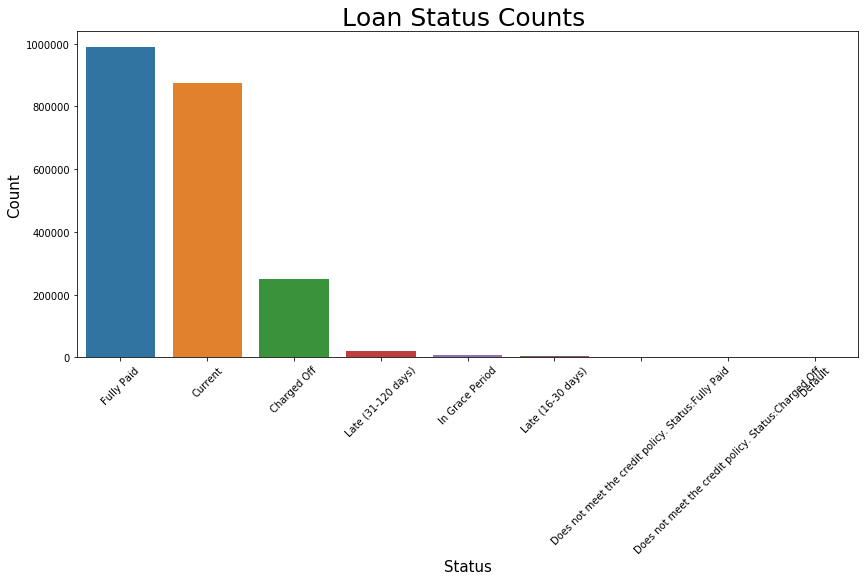

In [34]:
Plot_Counts_loanStatus(df)

** Conclusion **: A large proportion of the dataset constitute "Current" loans. These loans could contain "bad" clients as well who just have not defaulted YET. However, they could also contain fully credible clients. Therefore, the best approach when determining the probability of default would probably not include them at all.

Let us analyse these in a greater detail.

In [35]:
df_select = df[["loan_status","issue_d", "term", "last_pymnt_d"]]
df_select = df_select[df_select.loan_status== "Current"]


In [36]:
print(df_select.shape[0])
print("-------------------")
print(df_select["last_pymnt_d"].value_counts())

873710
-------------------
Feb-2019    863288
Jan-2019     10417
Jul-2018         3
Feb-2018         1
Oct-2018         1
Name: last_pymnt_d, dtype: int64


** Conclusions **: The vast majority of "Current" loans has a last payment date, ie Last month payment was received, in early 2019. This is plausible. These are probably truly current loans. There is however a small number of loans with last payment date in 2018. This could indicate that they could actually be defaulted loans, but for some reason, the system has not classified these as default yet.

In order to further assess this, I will investigate, derive and use the maturity date for all of the current loans.

In [37]:
df_select = CurrentAnalyser(df = df, current = "Current")

Analyse the potential candidates for a "fully paid" status. Expect those to be the entries for which last payment date will be the same as the loan maturity date.

In [38]:
df_select["pmt_comparison"] = df_select["last_pymnt_d"] == df_select["maturity_d"]
fully_paid_idx = df_select[df_select["pmt_comparison"] == True].index.tolist()
len(fully_paid_idx)

2661

In [39]:
df_select[df_select["pmt_comparison"] == True].head(10)

,loan_status,issue_d,last_pymnt_d,maturity_d,pmt_comparison
798539,Current,Feb-2016,2019-02-01,2019-02-01,True
757973,Current,Feb-2016,2019-02-01,2019-02-01,True
750697,Current,Feb-2016,2019-02-01,2019-02-01,True
782216,Current,Feb-2016,2019-02-01,2019-02-01,True
751799,Current,Feb-2016,2019-02-01,2019-02-01,True
2068093,Current,Feb-2014,2019-02-01,2019-02-01,True
770270,Current,Feb-2016,2019-02-01,2019-02-01,True
768523,Current,Feb-2016,2019-02-01,2019-02-01,True
759026,Current,Feb-2016,2019-02-01,2019-02-01,True
760216,Current,Feb-2016,2019-02-01,2019-02-01,True


** Conclusion **: We have a lot of evidence to assume that these are in fact fully paid loans, as the last payment received was when the loans matured. There might indeed be some loans that will still need to make some payments to cover the whole loan amount (oustanding loan amount), but either way, these are not defaults. Hence, I will treat them as non-defaults in the subsequent analysis.

=======> change to ** fully-paid **

Analyse the potential candidates for default loans:

In [40]:
df_select["pmt_comparison"] = df_select["last_pymnt_d"] < df_select["maturity_d"]
df_select[df_select["pmt_comparison"] == True]["last_pymnt_d"].value_counts()

2019-02-01    860223
2019-01-01     10412
2018-07-01         1
Name: last_pymnt_d, dtype: int64

In [41]:
cutoff_date = '2019-01-01'
defaults_idx = df_select[(df_select["pmt_comparison"] == True) & df_select["last_pymnt_d"]\
                     .apply(lambda x: True if x < pd.Timestamp(cutoff_date) else False)]\
.index.tolist()

In [42]:
current_idx = df_select[(df_select["pmt_comparison"] == True) & df_select["last_pymnt_d"]\
                     .apply(lambda x: True if x >= pd.Timestamp(cutoff_date) else False)]\
.index.tolist()

** Conclusion **: We have a lot of evidence to assume that the loans with last payment in 2018 are in fact default loans as the last payment was received long before the maturity of the loan. All other loans, i.e. those with last payment in early 2019 are in fact truly current loans, as they are still in payment and the maturity date is long into the future.

=======> change to ** default ** and ** current ** respectively

Now let's analyse all remaining current loans:

In [43]:
df_select["pmt_comparison"] = df_select["last_pymnt_d"]>df_select["maturity_d"]
various_idx = df_select[df_select["pmt_comparison"] == True].index.tolist()


These are the loans for which last payment date was reported after the maturity date.. This could be because they are repaying old obligatins and so in fact could be classified "bad loans" or be due to system errors when in fact the loans had already been repaid but the processing of the transaction has occured later. Because of these, they likely carry little predictive information and could introduce unnecessary noise to the data and distort the results of the analysis.

=======> delete ** various **

Applying the above transformations to the datasets:

In [44]:
df_select = CurrentAnalyser(df = df, current = "Current")
fully_paid_idx, defaults_idx, various_to_idx, current_to_idx = Loan_statusCurrent_Replacer(df_select = df_select, cutoff_date = '2019-01-01')
df = df.drop(current_to_idx + various_to_idx, axis = 0)
df.loc[fully_paid_idx,'loan_status'] = "Fully Paid"
df.loc[defaults_idx,'loan_status'] = "Default"

del fully_paid_idx, defaults_idx, various_to_idx, current_to_idx, df_select

In [45]:
df_select_t = CurrentAnalyser(df = df_t, current = "Current")
fully_paid_idx_t, defaults_idx_t, various_to_idx_t, current_to_idx_t = Loan_statusCurrent_Replacer(df_select = df_select_t, cutoff_date = '2019-01-01')
df_t = df_t.drop(current_to_idx_t + various_to_idx_t, axis = 0)
df_t.loc[fully_paid_idx_t,'loan_status'] = "Fully Paid"
df_t.loc[defaults_idx_t,'loan_status'] = "Default"

del fully_paid_idx_t, defaults_idx_t, various_to_idx_t, current_to_idx_t, df_select_t

Plotting Count-Plots again as part of checks:

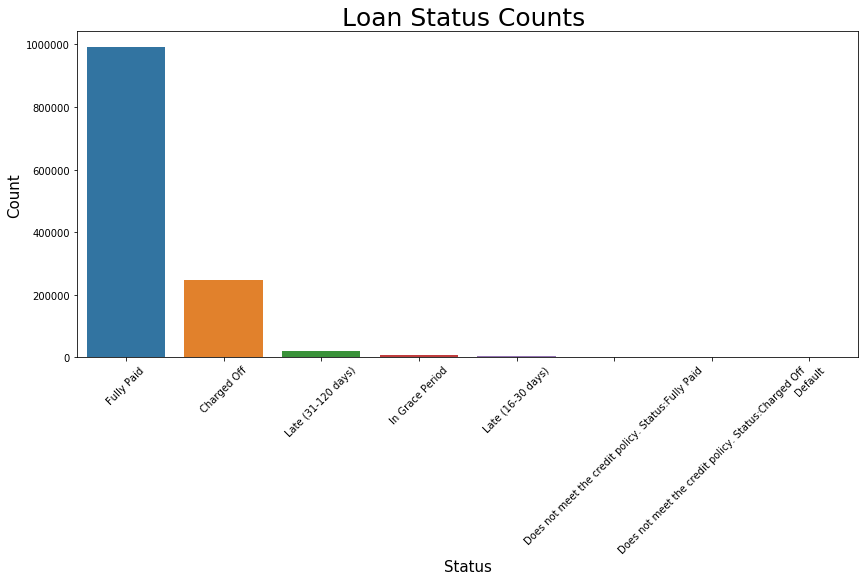

In [46]:
Plot_Counts_loanStatus(df)

In [47]:
df["loan_status"].value_counts()

Fully Paid                                             992515
Charged Off                                            248572
Late (31-120 days)                                      20802
In Grace Period                                          8504
Late (16-30 days)                                        3550
Does not meet the credit policy. Status:Fully Paid       1889
Does not meet the credit policy. Status:Charged Off       723
Default                                                    31
Name: loan_status, dtype: int64

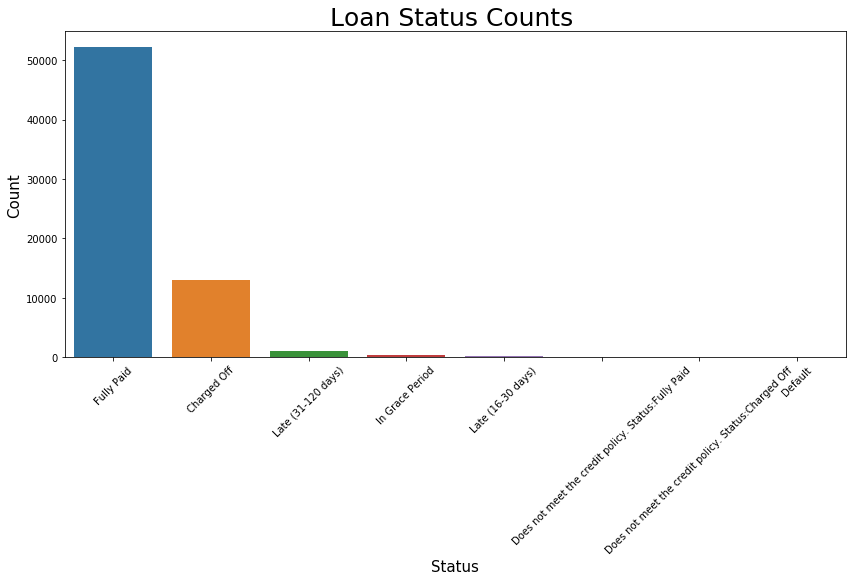

In [48]:
Plot_Counts_loanStatus(df_t)

In [49]:
df_t["loan_status"].value_counts()

Fully Paid                                             52225
Charged Off                                            13083
Late (31-120 days)                                      1095
In Grace Period                                          448
Late (16-30 days)                                        187
Does not meet the credit policy. Status:Fully Paid        99
Does not meet the credit policy. Status:Charged Off       38
Default                                                    1
Name: loan_status, dtype: int64

In [50]:
df['loan_status'] = convert2Binary(df['loan_status'], defaults_list)
df_t['loan_status'] = convert2Binary(df_t['loan_status'], defaults_list)

### Missing Values Analysis

In [51]:
MissingReport(df, diff_notation = False)

Percentages of Missing values:
---- id ---
100.0
---- member_id ---
100.0
---- loan_amnt ---
0.0
---- funded_amnt ---
0.0
---- funded_amnt_inv ---
0.0
---- term ---
0.0
---- int_rate ---
0.0
---- installment ---
0.0
---- grade ---
0.0
---- sub_grade ---
0.0
---- emp_title ---
6.412963952291502
---- emp_length ---
5.855539697286356
---- home_ownership ---
0.0
---- annual_inc ---
0.0003133357251293685
---- verification_status ---
0.0
---- issue_d ---
0.0
---- pymnt_plan ---
0.0
---- url ---
100.0
---- desc ---
90.63596185450882
---- purpose ---
0.0
---- title ---
1.201172502283434
---- zip_code ---
7.833393128234212e-05
---- addr_state ---
0.0
---- dti ---
0.026320200910866953
---- delinq_2yrs ---
0.0021150161446232374
---- earliest_cr_line ---
0.0021150161446232374
---- inq_last_6mths ---
0.0021933500759055793
---- mths_since_last_delinq ---
50.326809161309924
---- mths_since_last_record ---
82.94349146865154
---- open_acc ---
0.0021150161446232374
---- pub_rec ---
0.0021150161446232374

** Conclusion **: There is a high number of variables with a lot of missing values. In principle, if the "missingness" of the values is random, but we want to keep these features, we would replace the missing values with statistics inferred from the remaining values (e.g. mean, mode, or the most frequent value). If the number of missing values is high however, these estimates would not be very accurate and could introduce too much noise to the data.

One could also argue that the fact the values are missing could have something in common with the default / non-default status of the loan. However, the number of defaults is very small (0.1%) and the number of features is high, hence we are safe here to delete columns with a high number of values missing.

I will delete the columns which contain more than 20% of missing data.

In [52]:
missing_col = MissingColNames(threshold = 20)
missing_col.fit(df)
columns_to_drop = missing_col.print_list(df) + UniqueReport(df)
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)

del missing_col, columns_to_drop, dropper

Analysis of rows in which the remaining missing data is present and the pattern of these

In [53]:
ReturnMissingRows(df)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,...,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status
1310118,21000,21000,21000.000000,36 months,11.44,691.90,B,B4,Facilities technician,10+ years,MORTGAGE,95000.0,Source Verified,Feb-2015,n,debt_consolidation,Debt consolidation,071xx,NJ,3.13,1.0,Dec-1995,0.0,9.0,0.0,7625,28.2,16.0,w,0.00,0.00,24894.923621,24894.92,21000.00,3894.92,0.00,0.00,0.0000,Feb-2018,691.77,...,27000.0,1.0,39151.0,13346.0,27.5,0.0,0.0,144.0,127.0,26.0,22.0,6.0,27.0,NaN,1.0,1.0,3.0,2.0,3.0,1.0,5.0,8.0,3.0,9.0,0.0,0.0,1.0,0.0,87.5,0.0,0.0,0.0,521021.0,11348.0,18400.0,0.0,N,Cash,N,0
677673,12000,12000,12000.000000,36 months,5.32,361.38,A,A1,Registered Nurse,< 1 year,RENT,125000.0,Not Verified,Apr-2016,n,medical,Medical expenses,944xx,CA,7.88,0.0,Oct-1974,0.0,12.0,0.0,12588,43.1,18.0,w,0.00,0.00,12716.500945,12716.50,12000.00,716.50,0.00,0.00,0.0000,Jun-2018,385.55,...,29200.0,0.0,2612.0,16612.0,43.1,0.0,0.0,200.0,498.0,53.0,53.0,0.0,53.0,NaN,0.0,4.0,4.0,4.0,7.0,10.0,4.0,8.0,4.0,12.0,0.0,0.0,0.0,0.0,100.0,25.0,0.0,0.0,85958.0,31339.0,29200.0,56758.0,N,Cash,N,0
1411081,5000,5000,5000.000000,36 months,5.32,150.58,A,A1,NaN,NaN,OWN,24000.0,Verified,Feb-2017,n,home_improvement,Home improvement,857xx,AZ,2.10,0.0,Nov-1977,0.0,8.0,1.0,161,1.0,21.0,w,0.00,0.00,5245.435619,5245.44,5000.00,245.44,0.00,0.00,0.0000,Mar-2018,3439.96,...,16700.0,3.0,23.0,13610.0,0.7,0.0,0.0,107.0,471.0,10.0,10.0,0.0,10.0,NaN,0.0,1.0,2.0,5.0,9.0,5.0,7.0,15.0,2.0,7.0,0.0,0.0,0.0,1.0,100.0,0.0,1.0,0.0,16700.0,161.0,13700.0,0.0,N,Cash,N,0
1744522,12000,12000,11975.000000,36 months,7.90,375.49,A,A4,Tulare County,7 years,MORTGAGE,42000.0,Verified,Aug-2013,n,debt_consolidation,Consolidated dibt,932xx,CA,21.49,0.0,Mar-1985,0.0,23.0,1.0,12426,41.3,32.0,f,0.00,0.00,13506.109992,13477.97,12000.00,1506.11,0.00,0.00,0.0000,May-2016,1490.43,...,30100.0,2.0,8189.0,6193.0,56.7,0.0,0.0,67.0,345.0,10.0,10.0,1.0,19.0,NaN,0.0,3.0,11.0,4.0,6.0,9.0,16.0,22.0,11.0,23.0,0.0,0.0,0.0,1.0,90.0,33.3,1.0,0.0,206455.0,40756.0,14300.0,39302.0,N,Cash,N,0
2045182,5500,5500,5500.000000,36 months,9.67,176.62,B,B1,NaN,NaN,RENT,18000.0,Verified,Apr-2014,n,credit_card,Credit card refinancing,140xx,NY,20.27,0.0,Dec-1989,0.0,6.0,0.0,3443,65.0,14.0,w,0.00,0.00,6379.705358,6379.71,5500.00,879.71,0.00,0.00,0.0000,May-2017,187.34,...,5300.0,4.0,710.0,115.0,96.2,0.0,0.0,156.0,292.0,8.0,8.0,0.0,8.0,21.0,0.0,3.0,4.0,3.0,7.0,3.0,5.0,11.0,4.0,6.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,10218.0,4262.0,3000.0,4918.0,N,Cash,N,0
1919990,16000,16000,16000.000000,36 months,10.99,523.75,B,B3,assistance super,10+ years,MORTGAGE,50000.0,Not Verified,Oct-2014,n,debt_consolidation,Debt consolidation,114xx,NY,14.52,1.0,Mar-1992,1.0,19.0,0.0,13501,28.0,24.0,f,0.00,0.00,18844.963071,18844.96,16000.00,2844.96,0.00,0.00,0.0000,Oct-2017,523.48,...,47680.0,6.0,2226.0,2739.0,31.0,0.0,0.0,132.0,271.0,1.0,1.0,1.0,3.0,3.0,0.0,11.0,17.0,12.0,12.0,2.0,17.0,21.0,12.0,19.0,NaN,0.0,0.0,5.0,92.0,9.1,0.

In [54]:
df2 = df[df.isnull().any(axis=1)]
df2[df2["loan_status"]==1].shape[0]/np.sum(df["loan_status"]==1)

0.2717323477175635

In [55]:
df2 = df[df.isnull().any(axis=1)]
df2[df2["loan_status"]==0].shape[0]/np.sum(df["loan_status"]==0)

0.26875508161238715

In [56]:
del df2

** Conclusion**: Although this is not the best check for testing for meaningfulness of missing data, due to the multitute of variables and datapoints, I this it is good enough. The pattern of missing values is quite random. Moreover, the proportion of missing values among the defaults and non-defaults is similar. Hence it is justified to just delete the rows containing missing values from subsequent analysis.

Moreover, in general: 
* for categorical variables it might be reasonable to replace these data with e.g. an "X" value, which will then be converted to one-hot values (this could also be artificially done for numerical variables as well, for example we could create a binary column with "1" if the data was missing and "0" if it was not) ===> This approach would be preferable in general, however as there is already a lot of data and the above observations, it should not harm the model if we delete these data from the set.
* however, replacing the missing values with their mean e.g. could introduce some incorrect information to the dataset and distort the results of the analysis

======> delete rows with missing data

In [57]:
df.dropna(inplace = True)
df_t.dropna(inplace = True)

### Let us now analyse variables at a more granular level

## Correlations

#### NUMERICAL

In general, correlations are not a great representation of association between the variables. They are most effective when measuring relationships between two numerical features and can detect linear, monotonic associations only. However, they will help us find almost identical variables from the point of view of data analysis and information saturation and so will help us reduce the dimensionality of the feature space.

In [58]:
corr = df.corr()

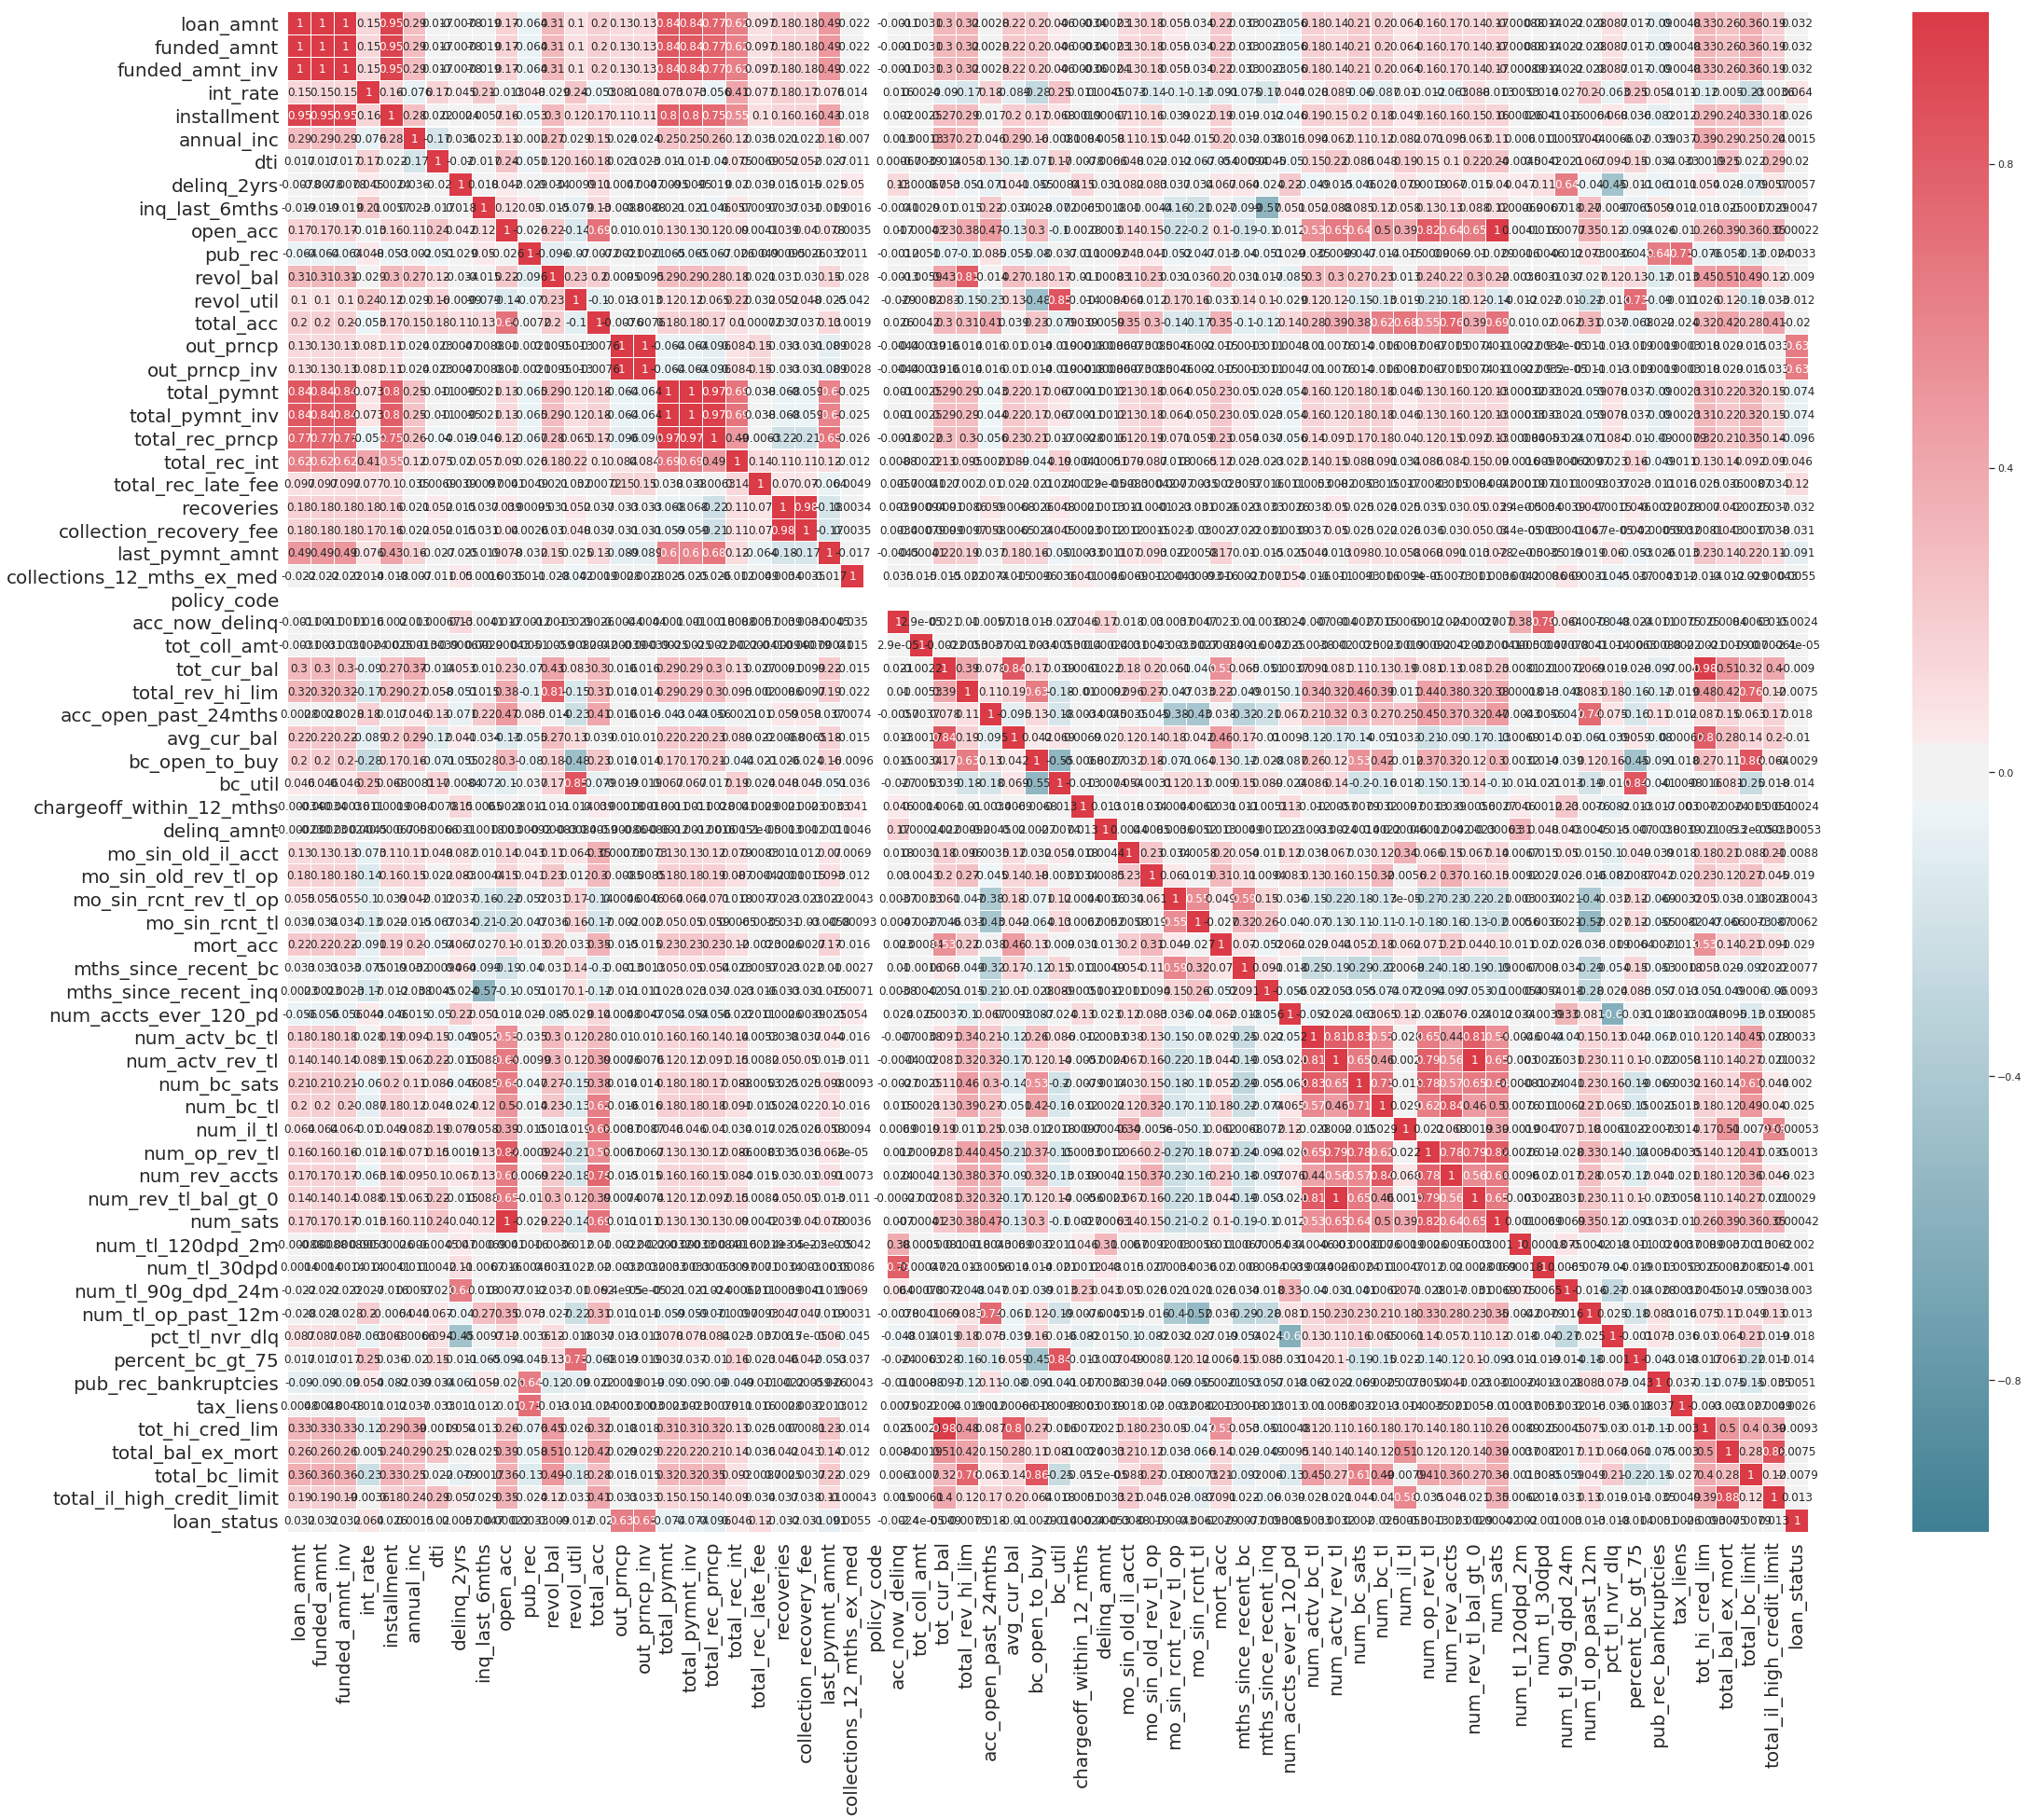

In [59]:
sn.set(style="white")


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 30))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sn.heatmap(corr, cmap=cmap, vmax=1, vmin = -1, center = 0,
            square=True,linewidths=.1, cbar_kws={"shrink": 1}, ax=ax,
               annot = True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize =20)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize =20)
plt.show()

I set threshold for "similarity" at (-1, -0.9) U (0.9, 1):

In [60]:
cr_list = CorrReport(correlation_matrix = corr, threshold = 0.90) 
cr_list

['collection_recovery_fee',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'out_prncp_inv',
 'tot_hi_cred_lim',
 'total_pymnt_inv',
 'total_rec_prncp']

** Conclusions **: Becasue these variables are highly correlated with other features present in the dataset, they will not add a lot of new information to the analysis and are likely to be excluded my machine learning algorithms anyway. Hence, I will "take some burden" from the algorthms away and from myself as well (by making the calculations slightly less complex, computer-intensive and so shortening the training / waiting time) and delete these from the dataset entirely now.

The above function takes into account the order in which the features appear in the dataset, keeping the first variable from each of the the correlated variables bundles.

In [61]:
dropper = DropColumns(columns_to_drop = cr_list)
df = dropper.transform(df)
df_t = dropper.transform(df_t)

#### I will now have a more detailed look at the CATEGORICAL variables:

In [62]:
selector = ColumnsSelectorByType(object)
df_cat = pd.concat([selector.fit_transform(df), df["loan_status"]], axis = 1)

del selector

df_cat.head(10)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag,loan_status
1977841,36 months,E,E5,manager,3 years,OWN,Verified,Jul-2014,n,other,Other,354xx,AL,Nov-1986,w,May-2016,Feb-2019,Individual,N,Cash,N,0
1195131,60 months,E,E5,CUSTODAIN,4 years,RENT,Source Verified,Jun-2015,n,debt_consolidation,Debt consolidation,070xx,NJ,Nov-1995,w,Dec-2017,Apr-2018,Individual,N,Cash,N,0
1564677,36 months,A,A1,Director of Operations,2 years,RENT,Not Verified,Jul-2017,n,credit_card,Credit card refinancing,927xx,CA,Oct-1989,w,Mar-2018,Apr-2018,Individual,N,Cash,N,0
816807,36 months,B,B2,Pharmaceutical Sales Rep,10+ years,MORTGAGE,Verified,Jan-2016,n,debt_consolidation,Debt consolidation,321xx,FL,Aug-1995,w,Dec-2016,Jul-2018,Individual,N,Cash,N,0
2000825,36 months,B,B1,principal,3 years,MORTGAGE,Verified,Jun-2014,n,credit_card,Credit card refinancing,080xx,NJ,Jul-1997,f,Feb-2016,Jan-2019,Individual,N,Cash,N,0
500617,36 months,C,C2,POC Sales Specialist,< 1 year,RENT,Source Verified,Sep-2016,n,moving,Moving and relocation,384xx,TN,Apr-1993,f,Aug-2017,Jul-2017,Individual,N,Cash,N,0
1690210,36 months,C,C1,Project Manager,6 years,MORTGAGE,Not Verified,Nov-2013,n,credit_card,Credit card refinancing,201xx,VA,Sep-2003,w,Jun-2015,Sep-2018,Individual,N,Cash,N,0
282388,36 months,B,B3,Analyst I,2 years,OWN,Source Verified,Jun-2018,n,credit_card,Credit card refinancing,018xx,MA,Dec-2002,w,Oct-2018,Feb-2019,Individual,N,Cash,N,0
108061,60 months,E,E5,Construction Supervisor,< 1 year,RENT,Not Verified,Oct-2018,n,other,Other,231xx,VA,Oct-2006,w,Dec-2018,Feb-2019,Individual,N,Cash,N,1
1169213,36 months,D,D4,advance senior analyst,10+ years,RENT,Source Verified,Jun-2015,n,other,Other,773xx,TX,May-1998,f,Jul-2017,Feb-2019,Individual,N,Cash,N,0


In general, in such cases when there is a lot of variables, a machine learning algorithm (such as those based on trees) could help detect features carrying the most information and perform variable selection. I will also do it later on. However, I will first have a look at these variables, also to assess if they require any additional pre-processing. I will now analyse these one by one:

In [63]:
Categorical_Report(df_cat, target = 'loan_status')

term
---- no.of unique values ----
2
---- Value Counts ----
 36 months    690828
 60 months    242607
Name: term, dtype: int64
None
term          36 months   60 months
loan_status                        
0              0.987489    0.973088
1              0.012511    0.026912
grade
---- no.of unique values ----
7
---- Value Counts ----
C    272190
B    266975
A    151873
D    143252
E     68338
F     23817
G      6990
Name: grade, dtype: int64
None
grade               A         B    ...            F         G
loan_status                        ...                       
0            0.994146  0.988126    ...     0.977369  0.971245
1            0.005854  0.011874    ...     0.022631  0.028755

[2 rows x 7 columns]
sub_grade
---- no.of unique values ----
35
---- Value Counts ----
C1    59529
B4    57243
B5    56614
C2    55172
B3    54835
C4    54070
C3    53983
B2    50111
C5    49436
B1    48172
A5    42939
D1    36425
A4    33438
D2    31717
D3    28000
A1    27328
D4    25409
A3    24

** Conclusions: **

#### Let us now analyse each variable separately and propose appropriate approach:
 * ***term*** : two different levels, slightly different proportions in each of the different levels groups ===> **one-hot encoding**
 * ***grade*** : seven different levels, different proportions in each of the different levels groups ===> **one-hot encoding**
 * ***sub_grade*** : 35 different levels, largely contributing the same information as grade (albeit on a more granular level, but this is likely not as important) ===> **delete**
 * ***emp_title*** : many different levels, this is a text type data, in order to assess its predictive power I will use methods appropriate for natural language processing ===> **assess using NLP methods**
 * ***emp_length*** : 12 different levels ===> **one-hot encoding**
 * ***home_ownership*** : 6 different levels, slightly different proportions in each of the different levels groups ===> **one-hot encoding**
 * ***verification_status*** : 3 different levels, some differences in proportions in each of the different levels groups ===> **one-hot encoding**
 * ***issue_d*** : date ===> **date; analyse further**
 * ***pymnt_plan*** : 2 levels, very different proportion in each of the different groups, payment plan is usually put in place when a loan is in default, therefore this is conditional on the loan_status and so is a leaky feature ===> **delete**
 * ***purpose*** : 14 levels, some differences ===> **one-hot encoding**
 * ***title*** : too many levels, similar to purpose ===> **delete**
 * ***zip_code*** : 905 levels, too many levels, similar to addr_state below ===> **delete**
 * ***addr_state*** : some levels ===> **one-hot encoding**
 * ***earliest_cr_line*** : date ===> **date; analyse further**
 * ***initial_list_status*** : 2 levels, signficant proportions across the two levels ===> **one-hot encoding**
 * ***last_pymnt_d*** : date ===> **date; analyse further**
 * ***last_credit_pull_d*** : date ===> **date; analyse further**
 * ***application_type*** : 2 levels, signficant proportions across the two levels ===> **one-hot encoding**
 * ***hardship_flag*** : 2 levels, signficant proportions across the two levels ===> **one-hot encoding**
 * ***disbursement_method*** : 2 levels, signficant proportions across the two levels ===> **one-hot encoding**
 * ***debt_settlement_flag*** : 2 levels, signficant proportions across the two levels ===> **one-hot encoding**



**TODO**: I have analysed the variable by eye examination. An idea to make this project more "standardised" and less prone to error would be to use for example statistical tests such as ANOVA (to assess if there are any meaningful differences in the means across the two default groups). This is an idea of extending this analysis in the future.

### Analyse the *emp_title* using NLP methods

Employer title is a text data. In order to assess its usefullness for this analysis, NLP methods will need to be applied.

In [64]:
temp_empl = df['emp_title']
temp_empl_df = pd.concat([temp_empl, df["loan_status"]], axis = 1)

In [65]:
nlp_data_temp = NLPTransformer(temp_empl_df, col_list = ['emp_title'])
nlp_data_temp.lowercase()
nlp_data_temp.fltr_stopwords()
nlp_data = nlp_data_temp.show()
nlp_data = nlp_data[['emp_title', 'loan_status']]
del nlp_data_temp

**Undersampling**
* The dataset is highly imbalanced. Because as a matter of urgency it is to predict "defaults" (as this would be more costly for us to fail to identify a "default" rather than marking a non-default as a default), we need to pay more attention on the "1" classes

* Dealing with class imbalances: 
- setting weights
- defining custom metrics for loss (e.g. focal loss)
- undersampling the majority class
- oversampling the minority class


* As the dataset is pretty large, the method chosen for this particular dataset is *"undersampling"* which should be good enough.

In [66]:
nlp_data = Undersampling(nlp_data, target = 'loan_status')

In [67]:
X_nlp = nlp_data['emp_title']
y_nlp = nlp_data['loan_status']

X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(X_nlp, y_nlp, test_size = 0.2, stratify = y_nlp, random_state=42) 
X_nlp_train, X_nlp_val, y_nlp_train, y_nlp_val = train_test_split(X_nlp_train, y_nlp_train, test_size = 0.1, stratify = y_nlp_train, random_state=42) 

del nlp_data

#### Building a NN Graph:
For the NLP analysis, I will use GRU. GRU entails some of the advantages of LSTM (i.e. the ability to learn sequences and sequencial data and so words commonly appearing together in a "sentence" or entry, although this is likely to be slightly less relevant here, so no need to use LSTM), but is computationally less intensive.

In [68]:
tokenizer_obj = Tokenizer() # vectorizes a text corpus
tokenizer_obj.fit_on_texts(X_nlp)
max_length = max([len(s) for s in X_nlp]) # max number of words in an index / row
nb_classes = len(set(y_nlp)) # number of distinct classes in the target variable
batch_size = 32
nb_epoch = 1000
num_sampled = 0.2*X_nlp.shape[0]

# define vocabulary size
vocabulary_size = len(tokenizer_obj.word_index) + 1 # number of distinct words in total

# define embedding size
embedding_size = 300 # typical size

In [69]:
# tokens
X_train_tokens = tokenizer_obj.texts_to_sequences(X_nlp_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_nlp_test)
X_val_tokens = tokenizer_obj.texts_to_sequences(X_nlp_val)

# pad sequences
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_length, padding = 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_length, padding = 'post')
X_val_pad = pad_sequences(X_val_tokens, maxlen = max_length, padding = 'post')

# y to categorical
y_train_cat = np_utils.to_categorical(y_nlp_train, nb_classes)
y_test_cat = np_utils.to_categorical(y_nlp_test, nb_classes)
y_val_cat = np_utils.to_categorical(y_nlp_val, nb_classes)

Training my own Embedding matrix will hopefully help to detect similar entries, for example 'it' to information technology, "hose kepping" to "house keeping", house wife, etc. CEO - "Chief Executive Director" and extract the contextual meaning of words

In [70]:
# train model
modelvec = Word2Vec(list(X_nlp)+['ansba'], min_count = 1, size = embedding_size)
# artificially added word because the model did not workon indices
# summarize the loaded model
print(modelvec)
embedding_matrix = modelvec.wv.syn0
print('Shape of embedding matrix: ', embedding_matrix.shape)

Word2Vec(vocab=6325, size=300, alpha=0.025)
Shape of embedding matrix:  (6325, 300)


In [71]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=True)

In [72]:
print('Building model...')
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print('Finished')

Building model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Finished


In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         1897500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,932,638
Trainable params: 1,932,638
Non-trainable params: 0
_________________________________________________________________


In [74]:
early_stopping = EarlyStopping(patience=3, monitor="val_acc")


model_fit = model.fit(X_train_pad,
                     y_train_cat,
                     epochs= nb_epoch,
                     batch_size=batch_size,
                     validation_data=(X_test_pad, y_test_cat),
                     callbacks=[early_stopping],
                     verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 21847 samples, validate on 6069 samples
Epoch 1/1000
 - 17s - loss: 0.6886 - acc: 0.5250 - val_loss: 0.6792 - val_acc: 0.5349
Epoch 2/1000
 - 16s - loss: 0.6500 - acc: 0.6015 - val_loss: 0.6940 - val_acc: 0.5475
Epoch 3/1000
 - 16s - loss: 0.5977 - acc: 0.6364 - val_loss: 0.7310 - val_acc: 0.5304
Epoch 4/1000
 - 16s - loss: 0.5629 - acc: 0.6551 - val_loss: 0.7781 - val_acc: 0.5443
Epoch 5/1000
 - 16s - loss: 0.5441 - acc: 0.6600 - val_loss: 0.7858 - val_acc: 0.5320


In [75]:
fname1 = 'nlp_preproc.pk'

In [76]:
# Use pickle to save model for next usage.
with open('./'+fname1, 'wb') as file:
    pickle.dump(model_fit, file) 

In [77]:
# Open saved model, and directly make the prediction with new data
with open('./'+fname1 ,'rb') as f:
    model_fit = pickle.load(f)

In [78]:
Evaluation_Report(model, X_val_pad, y_val_cat, y_nlp_val)

2428/2428 [==============================] - 0s 67us/step
Validation Evaluation Metrics:
 ---------------------
Validation Loss: 79.76%
Validation Accuracy: 52.80%
 ---------------------
Recall:  53.01%
Precision:  53.05%
F1 Score:  52.86%
Proportions of Classes in the Target Variable
 ---------------------
Predicted values
Percentage Composition of the classes:
 ---- class 0 ---
44.36%
 ---- class 1 ---
55.64%
 ---------------------
True values
Percentage Composition of the classes:
 ---- class 0 ---
50.00%
 ---- class 1 ---
50.00%


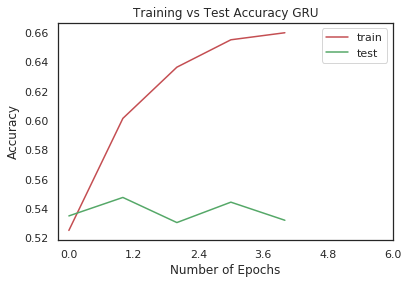

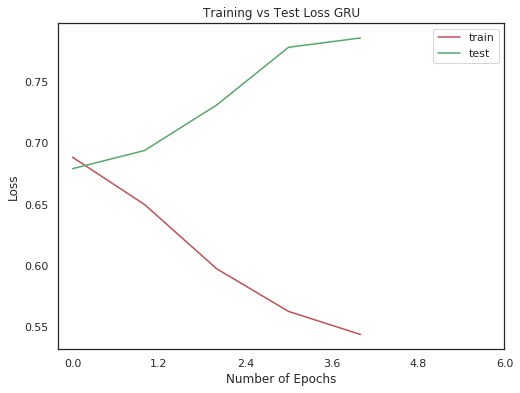

In [79]:
AccLoss_Plots(model_fit, nb_epoch = 6)

-------------------
Number of 'true' values in each class:
0 1214
1 1214
-------------------
Confusion Matrix:
[[575 502]
 [639 712]]
-------------------


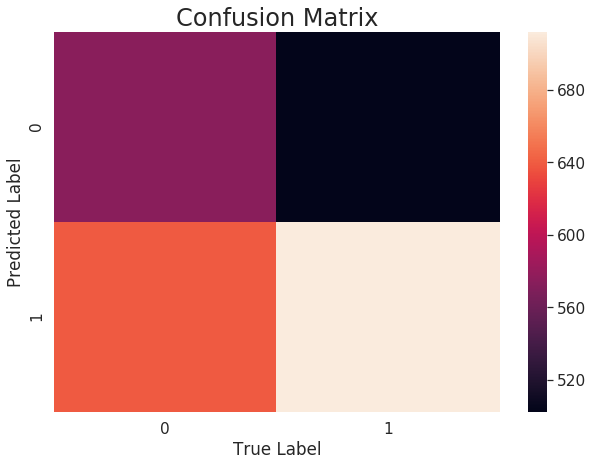

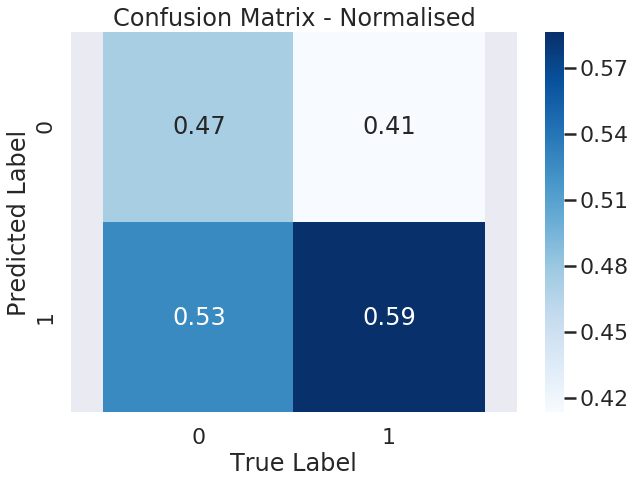

In [80]:
ConfusionMtx_Report(model, X_val_pad, y_val_cat)

** Conclusion **: The association between employer title and loan status is very small. Hence I will delete the emp_title feature from the dataset.

Deleting variables following the analysis of the categorical features:

### Dates' Analysis

In [81]:
col_name = 'issue_d'
Prop_CrosstabPrint2(data = df, col_name = col_name, target = 'loan_status')

issue_d,Apr-2013,Apr-2014,Apr-2015,Apr-2016,Apr-2017,Apr-2018,Aug-2012,Aug-2013,Aug-2014,Aug-2015,Aug-2016,Aug-2017,Aug-2018,Dec-2012,Dec-2013,Dec-2014,Dec-2015,Dec-2016,Dec-2017,Dec-2018,Feb-2013,Feb-2014,Feb-2015,Feb-2016,Feb-2017,Feb-2018,Jan-2013,Jan-2014,Jan-2015,Jan-2016,Jan-2017,Jan-2018,Jul-2013,Jul-2014,Jul-2015,Jul-2016,Jul-2017,Jul-2018,Jun-2013,Jun-2014,Jun-2015,Jun-2016,Jun-2017,Jun-2018,Mar-2013,Mar-2014,Mar-2015,Mar-2016,Mar-2017,Mar-2018,May-2013,May-2014,May-2015,May-2016,May-2017,May-2018,Nov-2012,Nov-2013,Nov-2014,Nov-2015,Nov-2016,Nov-2017,Nov-2018,Oct-2012,Oct-2013,Oct-2014,Oct-2015,Oct-2016,Oct-2017,Oct-2018,Sep-2012,Sep-2013,Sep-2014,Sep-2015,Sep-2016,Sep-2017,Sep-2018
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.998329,0.996831,0.985534,0.962683,0.889414,1.0,1.0,0.998541,0.995492,0.980374,0.945906,0.867619,1.0,0.999562,0.997488,0.991792,0.97064,0.923181,0.994074,1.0,0.999276,0.998222,0.989824,0.971104,0.911423,1.0,0.999143,0.997265,0.990768,0.969323,0.927824,1.0,0.998005,0.996247,0.981529,0.94851,0.86552,1.0,0.998548,0.99609,0.985294,0.95449,0.867861,1.0,0.998699,0.997081,0.986166,0.964755,0.904067,1.0,0.998827,0.996249,0.983996,0.959695,0.88314,1.0,1.0,0.997559,0.994227,0.974459,0.940159,0.93886,1.0,1.0,0.99805,0.995497,0.975742,0.935845,0.890149,1.0,1.0,0.997918,0.995272,0.979706,0.938017,0.868044
1,0.0,0.001671,0.003169,0.014466,0.037317,0.110586,0.0,0.0,0.001459,0.004508,0.019626,0.054094,0.132381,0.0,0.000438,0.002512,0.008208,0.02936,0.076819,0.005926,0.0,0.000724,0.001778,0.010176,0.028896,0.088577,0.0,0.000857,0.002735,0.009232,0.030677,0.072176,0.0,0.001995,0.003753,0.018471,0.05149,0.13448,0.0,0.001452,0.00391,0.014706,0.04551,0.132139,0.0,0.001301,0.002919,0.013834,0.035245,0.095933,0.0,0.001173,0.003751,0.016004,0.040305,0.11686,0.0,0.0,0.002441,0.005773,0.025541,0.059841,0.06114,0.0,0.0,0.00195,0.004503,0.024258,0.064155,0.109851,0.0,0.0,0.002082,0.004728,0.020294,0.061983,0.131956


** Conclusion **: There are some associations but they are rather small. There is a higher proportion of default loans issued in 2018, which could for example mean that some restrictions for credit had been relaxed. However, it is difficult to assess if this is indeed a beginning of such pattern from current data (would need to re-analyse this in the future if the same pattern happens in the future).

What could be more interesting to see is whether there is some association between defaults and months the loan had been issued, but there seems to be none. Therefore I will delete this variable from the dataset.

=======> delete

In [82]:
col_name = 'last_credit_pull_d'
Prop_CrosstabPrint2(data = df, col_name = col_name, target = 'loan_status')

last_credit_pull_d,Apr-2013,Apr-2014,Apr-2015,Apr-2016,Apr-2017,Apr-2018,Aug-2012,Aug-2013,Aug-2014,Aug-2015,Aug-2016,Aug-2017,Aug-2018,Dec-2012,Dec-2013,Dec-2014,Dec-2015,Dec-2016,Dec-2017,Dec-2018,Feb-2013,Feb-2014,Feb-2015,Feb-2016,Feb-2017,Feb-2018,Feb-2019,Jan-2013,Jan-2014,Jan-2015,Jan-2016,Jan-2017,Jan-2018,Jan-2019,Jul-2013,Jul-2014,Jul-2015,Jul-2016,Jul-2017,Jul-2018,Jun-2013,Jun-2014,Jun-2015,Jun-2016,Jun-2017,Jun-2018,Mar-2013,Mar-2014,Mar-2015,Mar-2016,Mar-2017,Mar-2018,Mar-2019,May-2013,May-2014,May-2015,May-2016,May-2017,May-2018,Nov-2012,Nov-2013,Nov-2014,Nov-2015,Nov-2016,Nov-2017,Nov-2018,Oct-2012,Oct-2013,Oct-2014,Oct-2015,Oct-2016,Oct-2017,Oct-2018,Sep-2012,Sep-2013,Sep-2014,Sep-2015,Sep-2016,Sep-2017,Sep-2018
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.999704,0.999769,0.999888,1.0,1.0,1.0,1.0,1.0,1.0,0.999812,1.0,1.0,1.0,1.0,1.0,0.999918,0.999101,1.0,1.0,1.0,1.0,0.999947,0.999806,0.957356,1.0,1.0,1.0,1.0,1.0,0.999872,0.999178,1.0,1.0,1.0,0.999708,0.999716,0.999849,1.0,1.0,1.0,1.0,0.99973,0.999715,1.0,1.0,1.0,1.0,1.0,0.999769,1.0,1.0,1.0,1.0,1.0,1.0,0.999785,1.0,1.0,1.0,1.0,1.0,0.99985,0.999172,1.0,1.0,1.0,1.0,0.99997,0.99987,0.999776,1.0,1.0,1.0,1.0,1.0,0.999131,0.999683
1,0.0,0.0,0.0,0.000296,0.000231,0.000112,0.0,0.0,0.0,0.0,0.0,0.0,0.000188,0.0,0.0,0.0,0.0,0.0,0.000082,0.000899,0.0,0.0,0.0,0.0,0.000053,0.000194,0.042644,0.0,0.0,0.0,0.0,0.0,0.000128,0.000822,0.0,0.0,0.0,0.000292,0.000284,0.000151,0.0,0.0,0.0,0.0,0.00027,0.000285,0.0,0.0,0.0,0.0,0.0,0.000231,0.0,0.0,0.0,0.0,0.0,0.0,0.000215,0.0,0.0,0.0,0.0,0.0,0.00015,0.000828,0.0,0.0,0.0,0.0,0.00003,0.00013,0.000224,0.0,0.0,0.0,0.0,0.0,0.000869,0.000317


** Conclusion **: Similar to the above ======> delete

In [83]:
col_name = 'earliest_cr_line'
Prop_CrosstabPrint2(data = df, col_name = col_name, target = 'loan_status')

earliest_cr_line,Apr-1934,Apr-1955,Apr-1958,Apr-1961,Apr-1962,Apr-1963,Apr-1964,Apr-1965,Apr-1966,Apr-1967,Apr-1968,Apr-1969,Apr-1970,Apr-1971,Apr-1972,Apr-1973,Apr-1974,Apr-1975,Apr-1976,Apr-1977,Apr-1978,Apr-1979,Apr-1980,Apr-1981,Apr-1982,Apr-1983,Apr-1984,Apr-1985,Apr-1986,Apr-1987,Apr-1988,Apr-1989,Apr-1990,Apr-1991,Apr-1992,Apr-1993,Apr-1994,Apr-1995,Apr-1996,Apr-1997,...,Sep-1976,Sep-1977,Sep-1978,Sep-1979,Sep-1980,Sep-1981,Sep-1982,Sep-1983,Sep-1984,Sep-1985,Sep-1986,Sep-1987,Sep-1988,Sep-1989,Sep-1990,Sep-1991,Sep-1992,Sep-1993,Sep-1994,Sep-1995,Sep-1996,Sep-1997,Sep-1998,Sep-1999,Sep-2000,Sep-2001,Sep-2002,Sep-2003,Sep-2004,Sep-2005,Sep-2006,Sep-2007,Sep-2008,Sep-2009,Sep-2010,Sep-2011,Sep-2012,Sep-2013,Sep-2014,Sep-2015
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.933333,0.96,1.0,0.958333,0.975,1.0,0.975,1.0,1.0,0.988889,1.0,0.992063,0.993243,0.995614,0.983333,0.977778,0.979866,0.982143,0.982,0.989583,0.991441,0.984287,0.987613,0.989708,0.991025,0.995142,0.995385,0.987635,0.979873,0.986758,0.986744,0.985223,0.988709,...,1.0,0.995098,0.990909,0.991304,0.987448,0.993377,0.994778,0.990724,0.986755,0.988604,0.983425,0.985265,0.987907,0.984899,0.991736,0.9883,0.984928,0.986914,0.990209,0.986276,0.98787,0.985434,0.989493,0.986271,0.987826,0.988726,0.985283,0.987178,0.980141,0.976158,0.976805,0.978867,0.977554,0.972595,0.97491,0.970543,0.955396,0.938719,0.856061,0.8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.04,0.0,0.041667,0.025,0.0,0.025,0.0,0.0,0.011111,0.0,0.007937,0.006757,0.004386,0.016667,0.022222,0.020134,0.017857,0.018,0.010417,0.008559,0.015713,0.012387,0.010292,0.008975,0.004858,0.004615,0.012365,0.020127,0.013242,0.013256,0.014777,0.011291,...,0.0,0.004902,0.009091,0.008696,0.012552,0.006623,0.005222,0.009276,0.013245,0.011396,0.016575,0.014735,0.012093,0.015101,0.008264,0.0117,0.015072,0.013086,0.009791,0.013724,0.01213,0.014566,0.010507,0.013729,0.012174,0.011274,0.014717,0.012822,0.019859,0.023842,0.023195,0.021133,0.022446,0.027405,0.02509,0.029457,0.044604,0.061281,0.143939,0.2


** Conclusion **: Similar to the above ======> delete

In [84]:
col_name = 'last_pymnt_d'
Prop_CrosstabPrint2(data = df, col_name = col_name, target = 'loan_status')

last_pymnt_d,Apr-2013,Apr-2014,Apr-2015,Apr-2016,Apr-2017,Apr-2018,Aug-2013,Aug-2014,Aug-2015,Aug-2016,Aug-2017,Aug-2018,Dec-2012,Dec-2013,Dec-2014,Dec-2015,Dec-2016,Dec-2017,Dec-2018,Feb-2013,Feb-2014,Feb-2015,Feb-2016,Feb-2017,Feb-2018,Feb-2019,Jan-2013,Jan-2014,Jan-2015,Jan-2016,Jan-2017,Jan-2018,Jan-2019,Jul-2013,Jul-2014,Jul-2015,Jul-2016,Jul-2017,Jul-2018,Jun-2013,Jun-2014,Jun-2015,Jun-2016,Jun-2017,Jun-2018,Mar-2013,Mar-2014,Mar-2015,Mar-2016,Mar-2017,Mar-2018,May-2013,May-2014,May-2015,May-2016,May-2017,May-2018,Nov-2012,Nov-2013,Nov-2014,Nov-2015,Nov-2016,Nov-2017,Nov-2018,Oct-2012,Oct-2013,Oct-2014,Oct-2015,Oct-2016,Oct-2017,Oct-2018,Sep-2012,Sep-2013,Sep-2014,Sep-2015,Sep-2016,Sep-2017,Sep-2018
loan_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.825668,1.0,1.0,1.0,1.0,1.0,1.0,0.879925,1.0,1.0,1.0,1.0,1.0,1.0,0.941124,1.0,1.0,1.0,1.0,1.0,0.999962,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.84346,1.0,1.0,1.0,1.0,1.0,1.0,0.886591,1.0,1.0,1.0,1.0,1.0,1.0,0.999554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174332,0.0,0.0,0.0,0.0,0.0,0.0,0.120075,0.0,0.0,0.0,0.0,0.0,0.0,0.058876,0.0,0.0,0.0,0.0,0.0,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15654,0.0,0.0,0.0,0.0,0.0,0.0,0.113409,0.0,0.0,0.0,0.0,0.0,0.0,0.000446


** Conclusion ** There seems to be a higher proportion of defaults if the last payment occured in the last half year.

======> bin these into categories

In [85]:
list_HY = ["Oct-2018", "Nov-2018", "Dec-2018", "Jan-2019", "Feb-2019", "Mar-2019"]

df["last_pymnt_d"] = df["last_pymnt_d"].apply(lambda x: "last_HY" if x in list_HY else "Other")
df_t["last_pymnt_d"] = df_t["last_pymnt_d"].apply(lambda x: "last_HY" if x in list_HY else "Other")

del list_HY

#### Delete columns following the analysis of categorical data

In [86]:
columns_to_drop = ["sub_grade", "emp_title", "title", "zip_code", "pymnt_plan"]
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)
del columns_to_drop

In [87]:
columns_to_drop = ["earliest_cr_line", "last_credit_pull_d", "issue_d"]
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)
del columns_to_drop

### Feature Engineering

* The feature set already contains a large and varied number of features. I could not think of any new useful variables that could be deduced

I will now again do the whole preprocessing below. This is in order to keep all the pre-rpcessing in one place. Some of the pre-processing steps will overlap with what was already done above during EDA.

# Pre-Processing All

In [88]:
gc.collect() # garbage collector - delete


# load data in chunks because of the dataset size
mylist = []  

for chunk in  pd.read_csv('../input/loan.csv', low_memory=False, chunksize=20000):
    mylist.append(chunk)

df = pd.concat(mylist, axis= 0)

del mylist

In [89]:
X = df.drop(['loan_status'], axis = 1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, stratify = y, random_state = 42)

df = pd.concat([X_train, y_train], axis = 1)
df_t = pd.concat([X_test, y_test], axis = 1)


del X, y, X_train, X_test, y_train, y_test

In [90]:
df_select = CurrentAnalyser(df = df, current = "Current")
fully_paid_idx, defaults_idx, various_to_idx, current_to_idx = Loan_statusCurrent_Replacer(df_select = df_select, cutoff_date = '2019-01-01')
df = df.drop(current_to_idx + various_to_idx, axis = 0)
df.loc[fully_paid_idx,'loan_status'] = "Fully Paid"
df.loc[defaults_idx,'loan_status'] = "Default"

del fully_paid_idx, defaults_idx, various_to_idx, current_to_idx, df_select

In [91]:
df_select_t = CurrentAnalyser(df = df_t, current = "Current")
fully_paid_idx_t, defaults_idx_t, various_to_idx_t, current_to_idx_t = Loan_statusCurrent_Replacer(df_select = df_select_t, cutoff_date = '2019-01-01')
df_t = df_t.drop(current_to_idx_t + various_to_idx_t, axis = 0)
df_t.loc[fully_paid_idx_t,'loan_status'] = "Fully Paid"
df_t.loc[defaults_idx_t,'loan_status'] = "Default"

del fully_paid_idx_t, defaults_idx_t, various_to_idx_t, current_to_idx_t, df_select_t

In [92]:
df['loan_status'] = convert2Binary(df['loan_status'], defaults_list)
df_t['loan_status'] = convert2Binary(df_t['loan_status'], defaults_list)

In [93]:
missing_col = MissingColNames(threshold = 20)
missing_col.fit(df)
columns_to_drop = missing_col.print_list(df) + UniqueReport(df)
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)

del missing_col, columns_to_drop, dropper

In [94]:
df.dropna(inplace = True)
df_t.dropna(inplace = True)

In [95]:
corr = df.corr()
dropper = DropColumns(columns_to_drop = CorrReport(correlation_matrix = corr, threshold = 0.90) )
df = dropper.transform(df)
df_t = dropper.transform(df_t)

del corr


In [96]:
list_HY = ["Oct-2018", "Nov-2018", "Dec-2018", "Jan-2019", "Feb-2019", "Mar-2019"]

df["last_pymnt_d"] = df["last_pymnt_d"].apply(lambda x: "last_HY" if x in list_HY else "Other")
df_t["last_pymnt_d"] = df_t["last_pymnt_d"].apply(lambda x: "last_HY" if x in list_HY else "Other")

del list_HY

In [97]:
columns_to_drop = ["sub_grade", "emp_title", "title", "zip_code", "pymnt_plan"]
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)
del columns_to_drop

In [98]:
columns_to_drop = ["earliest_cr_line", "last_credit_pull_d", "issue_d"]
dropper = DropColumns(columns_to_drop = columns_to_drop)
df = dropper.transform(df)
df_t = dropper.transform(df_t)
del columns_to_drop

#### One-Hot Encoding

In [99]:
onehot_col = Val2OneHot()
onehot_col.fit(df)
df = onehot_col.print_list(df)
df_t = onehot_col.print_list(df_t)

In [100]:
df = pd.get_dummies(df)
df_t = pd.get_dummies(df_t)   

In [101]:
common_cols = df.columns.intersection(df_t.columns).tolist()

In [102]:
df = df[common_cols]
df_t = df_t[common_cols]

In [103]:
del onehot_col, common_cols

### Sampling Methods

In [104]:
#df = sampleDataset(df, size = 400000, target = 'loan_status')

In [105]:
df = Undersampling(df, target = 'loan_status')

### Save Pre-Processed Dataframe

This is the end of the part done on Kaggle. The rest was done in Jupyter notebooks.

In [28]:
# # SAVE smaller dataset
# df.to_csv('df_m2.csv', index = False)
# df_t.to_csv('df_t_m2.csv', index = False)

In [91]:
df = pd.read_csv('./df_m2.csv', low_memory=False)
df_t = pd.read_csv('./df_t_m2.csv', low_memory=False)

## Dimensionality Reduction

For dimensionality reduction, I will use in-built into Python algorithms based on **random forests**. I will choose a smaller subset of variables (30) which give the most information into the model. I will the analyse the feature importances, however if these are not so significant for the later appearing variables, then we should be good. This is because it is best to build as simple and as informative model as possible if the metrics are sufficiently good. There is no sense to add too many variables (and increase model complexity) which bring negligible improvement in the evaluation metrics.

I will also address **data-leakage**.

In [92]:
y = df['loan_status'] # extract target variable
X = df.drop(['loan_status'], axis = 1) # extract feature set

y_test = df_t['loan_status'] # extract target variable
X_test = df_t.drop(['loan_status'], axis = 1) # extract feature set

In [93]:
# rfecv = RFECV(RandomForestClassifier(min_samples_leaf=5), 
#               step = 1, cv = StratifiedKFold(2), 
#               scoring = 'f1', verbose = 2)

# rfecv.fit(X, y)

In [32]:
# # Use pickle to save model for next usage.
# filename1 = 'rfecv.pk'
# with open('./'+filename1, 'wb') as file:
#     pickle.dump(rfecv, file) 

In [94]:
# Open saved model, and directly make the prediction with new data
filename1 = 'rfecv.pk'
with open('./'+filename1 ,'rb') as f:
    rfecv = pickle.load(f)

In [95]:
roc_auc_score(rfecv.predict(X_test),y_test)

0.817877901235322

In [96]:
df2 = pd.concat([df.iloc[:,rfecv.get_support().tolist()], df['loan_status'] ], axis = 1)
df2_t = pd.concat([df_t.iloc[:,rfecv.get_support().tolist()], df_t['loan_status'] ], axis = 1)

# df2 = df.iloc[:,rfecv.get_support().tolist()]
# df2_t = df_t.iloc[:,rfecv.get_support().tolist()]

In [100]:
y = df2['loan_status'] # extract target variable
X = df2.drop(['loan_status'], axis = 1) # extract feature set

y_test = df2_t['loan_status'] # extract target variable
X_test = df2_t.drop(['loan_status'], axis = 1) # extract feature set

In [40]:
# rfe = RFE(RandomForestClassifier(min_samples_leaf=5),
#           n_features_to_select = 30, verbose = 2)

# rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=30, step=1, verbose=2)

In [41]:
# # Use pickle to save model for next usage.
# filename2 = 'rfe.pk'
# with open('./'+filename2, 'wb') as file:
#     pickle.dump(rfe, file) 

In [101]:
# Open saved model, and directly make the prediction with new data
filename2 = 'rfe.pk'
with open('./'+filename2 ,'rb') as f:
    rfe = pickle.load(f)

In [102]:
roc_auc_score(rfe.predict(X_test),y_test)

0.8171374523292055

In [128]:
df3 = pd.concat([df2.iloc[:,rfe.get_support().tolist()], df['loan_status'] ], axis = 1)
df3_t = pd.concat([df2_t.iloc[:,rfe.get_support().tolist()], df_t['loan_status'] ], axis = 1)

In [129]:
common_cols = df3.columns.intersection(df2_t.columns).tolist()
df3 = df3[common_cols]
df3_t = df3_t[common_cols]

## Feature "Manual" Selection

In order to be able to truly **predict** the customer's default, I think we should be taking variables available to us beforehand. Hence those relating to the customer before giving the loan rather than available only when the loan had been repaid (or not). I can manually delete some variables such as total_pymnt = total payment received or total_rec_int = total interest received, info about the number of recoveries, however, these data seem to be taken at a point when it was readily known if the customer was in default or not.

It would be better to receive data of their characteristics before the loan was granted and then with the loan_status only. Such analysis would make more practical sense.

Therefore, I will quickly have a look at the selected variables and sense check their modelling viability.

In [130]:
df3.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util',
       'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_rev_accts',
       'total_bal_ex_mort', 'total_il_high_credit_limit', 'loan_status'],
      dtype='object')

* loan_amnt - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* int_rate - Interest Rate on the loan
* annual_inc - The self-reported annual income provided by the borrower during registration.
* dti - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* revol_bal - Total credit revolving balance
* revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* out_prncp - Remaining outstanding principal for total amount funded
* total_pymnt - Payments received to date for total amount funded
* total_rec_int - Interest received to date
* total_rec_late_fee - Late fees received to date
* recoveries - post charge off gross recovery
* last_pymnt_amnt - Last total payment amount received
* tot_cur_bal - Total current balance of all accounts
* total_rev_hi_lim - Total revolving high credit/credit limit
* acc_open_past_24mths - Number of trades opened in past 24 months.
* bc_open_to_buy - Total open to buy on revolving bankcards.
* bc_util - Ratio of total current balance to high credit/credit limit for all bankcard accounts.
* mo_sin_old_il_acct - Months since oldest bank installment account opened
* mo_sin_old_rev_tl_op - Months since oldest revolving account opened
* num_rev_accts - Number of revolving accounts
* total_bal_ex_mort - Total credit balance excluding mortgage
* total_il_high_credit_limit - Total installment high credit/credit limit

In [131]:
# out_prncp:
col_name = "out_prncp"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0      121.926737
1    11408.555438
Name: out_prncp, dtype: float64

In [132]:
df3[["loan_status",col_name]]

,loan_status,out_prncp
0,0,0.00
1,0,0.00
2,0,0.00
3,0,0.00
4,0,0.00
5,0,0.00
6,0,0.00
7,0,0.00
8,0,0.00
9,0,0.00


In [133]:
df_loan1 = df3[["loan_status",col_name]]
df_loan1 = df_loan1[df_loan1.loan_status== 1]
df_loan1.describe()

,loan_status,out_prncp
count,15172.0,15172.000000
mean,1.0,11408.555438
std,0.0,8450.210103
min,1.0,0.000000
25%,1.0,4753.687500
50%,1.0,9395.670000
75%,1.0,16182.070000
max,1.0,39595.020000


In [134]:
df_loan0 = df3[["loan_status",col_name]]
df_loan0 = df_loan0[df_loan0.loan_status== 0]
df_loan0.describe()

,loan_status,out_prncp
count,15172.0,15172.000000
mean,0.0,121.926737
std,0.0,1447.748004
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.000000
max,0.0,34680.110000


** Conclusion **: The values above indicate that there is a very strong relationship between the loan_status and out_prncp
variables, although this relationship is non-linear. Hence this has not been quite captured by the correlations
(only partially). Indeed, by intuition - if someone defaults they do have an outstanding amount to pay. Conversely, if they do not defaults, the remainig outstanding balance is zero (this holds true for most cases). Therefore I delete this value from my subsquent analysis.

In [135]:
# recoveries:
col_name = "recoveries"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    254.921154
1      0.000000
Name: recoveries, dtype: float64

Recoveries - this is a variable that could happen only post-charge off. Hence it will only contant a number greater than zero for default loans.
=======> delete

In [136]:
col_name = "revol_util"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    51.263400
1    49.044292
Name: revol_util, dtype: float64

In [137]:
col_name = "total_rec_late_fee"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0     1.734980
1    14.436763
Name: total_rec_late_fee, dtype: float64

In [138]:
col_name = "tot_cur_bal"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    149562.390192
1    138610.707224
Name: tot_cur_bal, dtype: float64

In [139]:
col_name = "total_rev_hi_lim"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    33116.972779
1    31049.439823
Name: total_rev_hi_lim, dtype: float64

In [140]:
col_name = "acc_open_past_24mths"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    5.047719
1    5.473965
Name: acc_open_past_24mths, dtype: float64

In [141]:
col_name = "bc_open_to_buy"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    10384.618310
1    10080.623385
Name: bc_open_to_buy, dtype: float64

In [142]:
col_name = "bc_util"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    59.599868
1    56.321975
Name: bc_util, dtype: float64

In [143]:
col_name = "mo_sin_old_il_acct"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    125.551081
1    122.010018
Name: mo_sin_old_il_acct, dtype: float64

In [144]:
col_name = "mo_sin_old_rev_tl_op"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    175.261403
1    162.920643
Name: mo_sin_old_rev_tl_op, dtype: float64

In [145]:
col_name = "num_rev_accts"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    14.914514
1    13.454390
Name: num_rev_accts, dtype: float64

In [146]:
col_name = "total_bal_ex_mort"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    53145.390258
1    56131.132481
Name: total_bal_ex_mort, dtype: float64

In [147]:
col_name = "total_il_high_credit_limit"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    45549.016346
1    50280.741893
Name: total_il_high_credit_limit, dtype: float64

I will now delete variables which are evident as carrying information synonymous to the loan status (including those with very high differences among different groups indicating that these variables are in fact the same)

In [148]:
dropper = DropColumns(columns_to_drop = ["out_prncp", "recoveries", "total_rec_late_fee"])
df3 = dropper.transform(df3)
df3_t = dropper.transform(df3_t)

del dropper, df_loan0, df_loan1

**TODO**: Build a better report, so that the differences in means are tested automatically for. A good idea would be to implement some statistical tests and statistics.

### Correlations

Correlations can act as a dimensionality reduction method. I have already excluded highly correlated variables when assessing numerical features, but for completeness, I will check that there are no very highly correlated variables, which would unneccessarily increase the training time. They can also be used to assess for data leakage. Although the response feature is binary (categorical), so correlation is not the most appropriate method for this reason, this could give us some pre-eliminary idea on the matter.


In [149]:
corr = df3.corr()

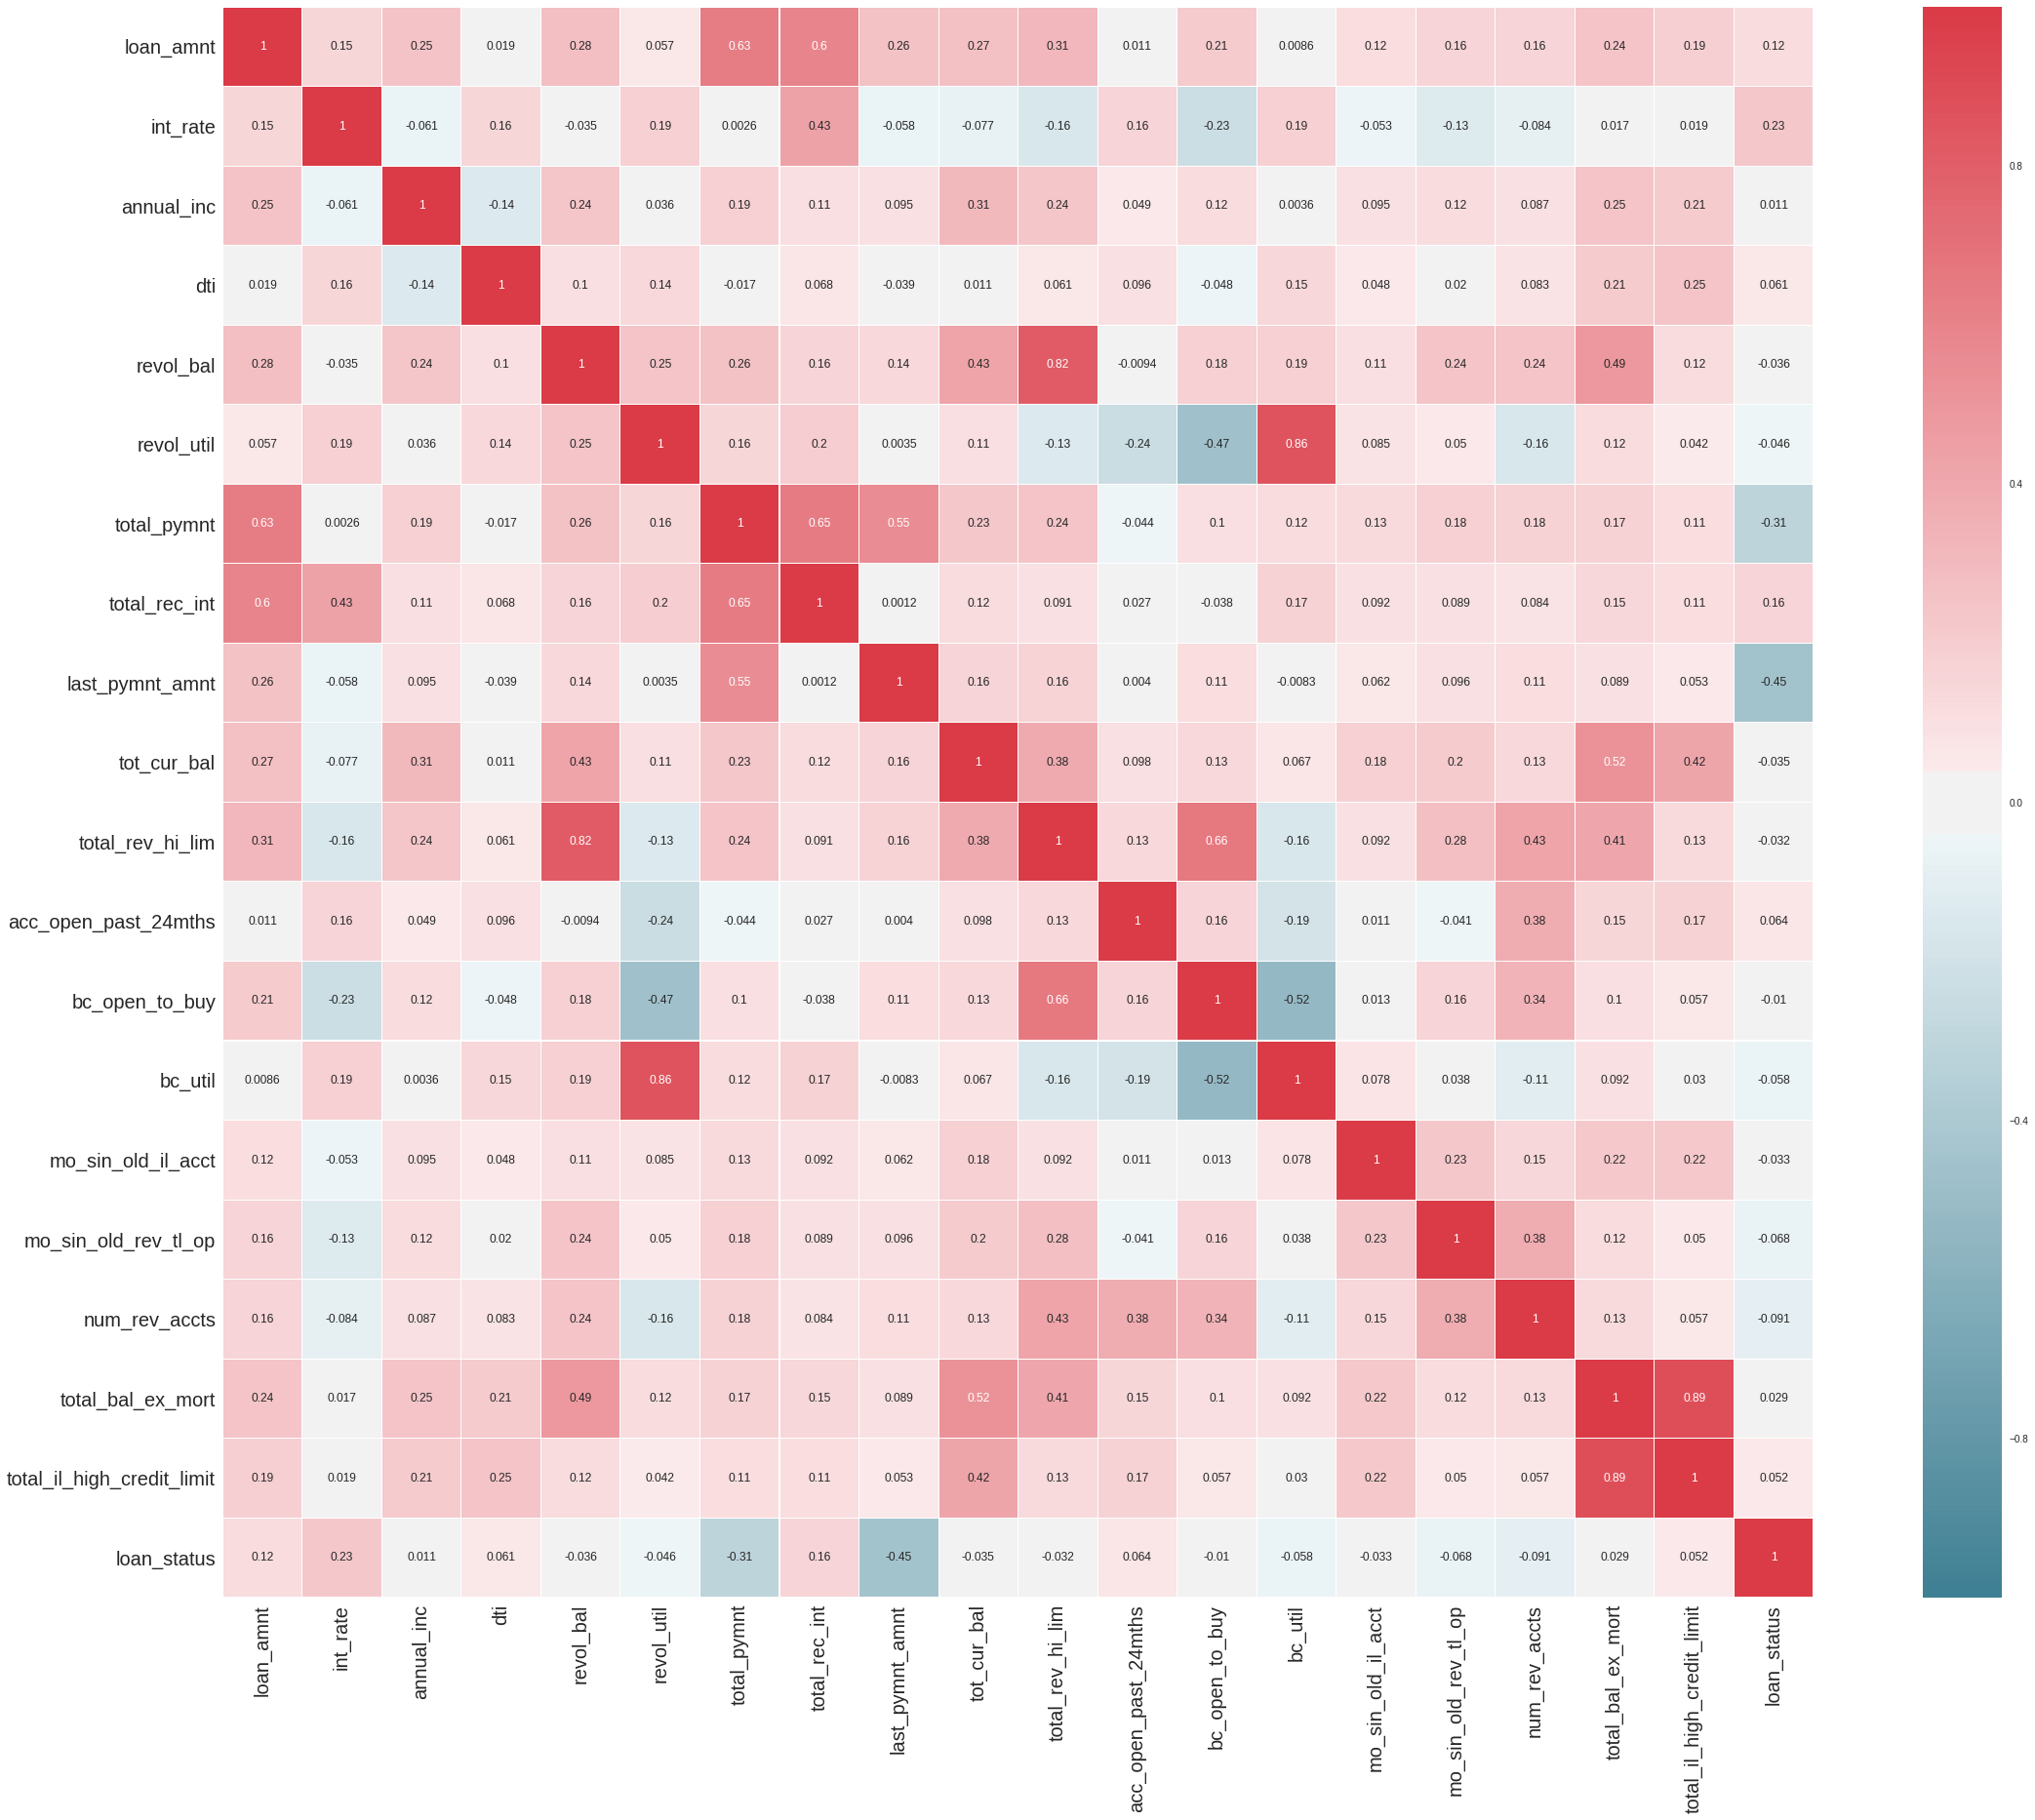

In [150]:
sn.set(style="white")


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 30))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sn.heatmap(corr, cmap=cmap, vmax=1, vmin = -1, center = 0,
            square=True,linewidths=.1, cbar_kws={"shrink": 1}, ax=ax,
               annot = True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize =20)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize =20)
plt.show()

In [151]:
corr

,loan_amnt,int_rate,annual_inc,dti,revol_bal,revol_util,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_rev_accts,total_bal_ex_mort,total_il_high_credit_limit,loan_status
loan_amnt,1.000000,0.149732,0.250578,0.019429,0.277567,0.056956,0.634196,0.601035,0.264679,0.269815,0.313865,0.010940,0.205898,0.008612,0.117026,0.162334,0.157476,0.243072,0.193489,0.122778
int_rate,0.149732,1.000000,-0.060839,0.155599,-0.035390,0.185152,0.002596,0.433727,-0.057678,-0.077482,-0.156451,0.160644,-0.230140,0.186297,-0.053297,-0.128594,-0.083675,0.017132,0.018705,0.233931
annual_inc,0.250578,-0.060839,1.000000,-0.137424,0.238112,0.035562,0.186408,0.107448,0.095037,0.311242,0.237719,0.048684,0.122487,0.003571,0.094624,0.119939,0.087448,0.247220,0.205211,0.010846
dti,0.019429,0.155599,-0.137424,1.000000,0.103271,0.136981,-0.017340,0.067895,-0.038759,0.011183,0.060649,0.095612,-0.047932,0.146112,0.047703,0.020342,0.083495,0.210021,0.245698,0.060856
revol_bal,0.277567,-0.035390,0.238112,0.103271,1.000000,0.246947,0.259452,0.158025,0.136440,0.426482,0.816721,-0.009385,0.181339,0.185864,0.107502,0.243015,0.242514,0.485865,0.120683,-0.036379
revol_util,0.056956,0.185152,0.035562,0.136981,0.246947,1.000000,0.155598,0.200950,0.003472,0.105694,-0.133146,-0.236159,-0.465013,0.860519,0.085459,0.049757,-0.162123,0.124617,0.042273,-0.045901
total_pymnt,0.634196,0.002596,0.186408,-0.017340,0.259452,0.155598,1.000000,0.647393,0.551931,0.230793,0.242531,-0.043617,0.103974,0.122968,0.127710,0.182567,0.177551,0.174292,0.110362,-0.310082
total_rec_int,0.601035,0.433727,0.107448,0.067895,0.158025,0.200950,0.647393,1.000000,0.001194,0.123582,0.091385,0.027000,-0.038284,0.174075,0.092125,0.088801,0.084324,0.146205,0.112627,0.158815
last_pymnt_amnt,0.264679,-0.057678,0.095037,-0.038759,0.136440,0.003472,0.551931,0.001194,1.000000,0.160038,0.164194,0.004044,0.111491,-0.008312,0.061534,0.095948,0.114162,0.089359,0.052540,-0.446047
tot_cur_bal,0.269815,-0.077482,0.311242,0.011183,0.426482,0.105694,0.230793,0.123582,0.160038,1.000000,0.384815,0.097918,0.134041,0.067132,0.183630,0.203951,0.132887,0.522619,0.418040,-0.034960


In [41]:
def CorrReport(correlation_matrix, threshold):
    corr_list = []
    for i in correlation_matrix.columns:
        if len(correlation_matrix.index[abs(correlation_matrix[i])>=threshold].tolist())>1:
            correlation_matrix = correlation_matrix.drop(i, axis = 0)
            corr_list.append(correlation_matrix.index[abs(correlation_matrix[i])>threshold])
        else:
            pass
    flat_list = [item for sublist in corr_list for item in sublist]

    return np.unique(flat_list).tolist()

In [152]:
corr_drop_list = CorrReport(correlation_matrix = corr, threshold = 0.87)

In [153]:
corr_drop_list

['total_il_high_credit_limit']

In [154]:
dropper = DropColumns(columns_to_drop = corr_drop_list)
df3 = dropper.transform(df3)
df3_t = dropper.transform(df3_t)

#### Data Leakage

**Conclusion**: 
* Quite high correlations of loan_status with total_pymnt and last_pymnt_amnt
* They could potentially be candidates for data leakage
* last_pymnt_amnt = Last total payment amount received
* total_pymnt = Payments received to date for total amount funded

By similar reasoning total_rec_int, which is total interest received to date should be looked into too.

Correlations are not a particularly good method for assessment of relationship, in particular where at least one of the variables is not numerical. However, it helped o identify candidates for data leakage.

**TODO**: A much better method would be to use a machine learning methods, such as a random forest model on training data (in order not to use information from the test dataset). If the evaluation metrics obtained are unusually high (say in the range 97%-100%) and there are a few variables (or one) that have disproportionately high feature importance, then most likely we would be faced with leaky data problem.

To further assess this, one could compare the means in different groups (just like done below), but instead of using eye examination, exploit a more robust approach by using statistical tests such as ANOVA. This is a good point to extend this analysis further.

In [155]:
# last_pymnt_amnt:
col_name = "last_pymnt_amnt"
leakageAnalysis(data = df3, col_name= col_name, target = "loan_status")

loan_status
0    5710.958027
1     528.659603
Name: last_pymnt_amnt, dtype: float64

In [156]:
df3[["loan_status",col_name]]

,loan_status,last_pymnt_amnt
0,0,665.71
1,0,746.07
2,0,4080.98
3,0,1050.72
4,0,369.74
5,0,12979.10
6,0,494.34
7,0,12201.92
8,0,265.56
9,0,183.00


In [157]:
df_loan1 = df3[["loan_status",col_name]]
df_loan1 = df_loan1[df_loan1.loan_status== 1]
df_loan1.describe()

,loan_status,last_pymnt_amnt
count,15172.0,15172.000000
mean,1.0,528.659603
std,0.0,654.076960
min,1.0,0.020000
25%,1.0,274.670000
50%,1.0,422.010000
75%,1.0,675.260000
max,1.0,25739.160000


In [158]:
df_loan0 = df3[["loan_status",col_name]]
df_loan0 = df_loan0[df_loan0.loan_status== 0]
df_loan0.describe()

,loan_status,last_pymnt_amnt
count,15172.0,15172.000000
mean,0.0,5710.958027
std,0.0,7323.923273
min,0.0,0.000000
25%,0.0,425.705000
50%,0.0,2313.385000
75%,0.0,8823.072500
max,0.0,41018.730000


** Conclusion **: As expected there is no direct association with the loan_status. It could generally be true that the higher the loan amount, the higher the probability of default, but probably only slightly because most banks will have their maximum lending dti thresholds.
The loan amount variable should not therefore be rejected. In fact, it is a very useful variable, for example, if we want to detect the aforementioned relationship

In [159]:
df3[["loan_status","total_pymnt", "loan_amnt"]]

,loan_status,total_pymnt,loan_amnt
0,0,11919.076813,10000
1,0,4441.230000,25500
2,0,15183.201541,12750
3,0,37839.567867,31200
4,0,13307.219801,11500
5,0,40142.780000,35000
6,0,21437.439988,17500
7,0,17788.485914,15000
8,0,5651.130000,10125
9,0,5542.361563,4225


** Conclusion **: together with loan amount describes the loan status almost exactly
    ===> delete

In [160]:
df3[["loan_status","total_rec_int", "int_rate"]]

,loan_status,total_rec_int,int_rate
0,0,1919.08,11.99
1,0,3062.25,24.84
2,0,2433.20,12.69
3,0,6639.57,12.99
4,0,1807.22,9.80
5,0,5142.78,10.15
6,0,10626.78,23.10
7,0,2788.49,13.99
8,0,2728.35,19.52
9,0,1317.36,18.99


** Conclusion **: Total interest to be paid = int_rate *loan_amnt
    If we compare this with the total interest paid, we can deduce the status of the loan. This variable is not available beforehand about the client, hence delete.

In [162]:
dropper = DropColumns(columns_to_drop = ["total_pymnt", "total_rec_int"])
df3 = dropper.transform(df3)
df3_t = dropper.transform(df3_t)

del dropper, df_loan0, df_loan1

### Train-Test Split

In [163]:
X = df3.drop(['loan_status'], axis = 1)
y = df3['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_test = df3_t.drop(['loan_status'], axis = 1)
y_test = df3_t['loan_status']

# Models

## Random Forest

In [164]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed) # parametr dla losowej cross-validation

models = Pipeline([("model",RandomForestClassifier(min_samples_leaf=5, class_weight = "balanced"))]) # pipeline dla modelu


param_grids = {"model__n_estimators": [10, 100, 500, 1000, 1200, 1400], 
               "model__max_features":['auto', 'sqrt']#, 
              #"model__class_weight":["balanced"]#, {0: 0.2, 1: 0.8}, {0: 0.4, 1: 0.6}, 
                                       #{0: 0.6, 1: 0.4}, {0: 0.8, 1: 0.2}]
              } # parametry, które hyper-tuningujemy / optymalizujemy


grid_1w = RandomizedSearchCV(models, param_grids, scoring='roc_auc', cv=kfold, verbose = 1, n_jobs = -1) # definiuje model, metoda ocenyjak najwyższy AUROC
grid_1w.fit(X_train, y_train)
print(roc_auc_score(y_val, grid_1w.best_estimator_.predict(X_val)),
        grid_1w.best_params_) # zwraca najwyzsza srednia "poprawność" modelu i parametry

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.9min finished


0.8151474393990568 {'model__n_estimators': 1200, 'model__max_features': 'auto'}


In [165]:
# # Use pickle to save model for next usage.
# filename3 = 'rf_m2.2.pk'
# with open('./'+filename3, 'wb') as file:
#     pickle.dump(grid_1w, file) 

In [166]:
# Open saved model, and directly make the prediction with new data
with open('./'+filename3 ,'rb') as f:
    grid_1w = pickle.load(f)

In [167]:
y_predw1 = grid_1w.predict(X_test) # predykcja uzywajac modelu
#y_predw1 = grid_1w.best_estimator_.predict(X_test)

In [168]:
#roc_auc_score(y_test, grid_1w.predict_proba(X_val)[:,1]) # auc dla predykcji
roc_auc_score(y_test, y_predw1)

0.8222373350894732

In [169]:
classification_report(y_test, y_predw1)

'              precision    recall  f1-score   support\n\n           0       1.00      0.70      0.82     48241\n           1       0.05      0.95      0.10       819\n\n   micro avg       0.70      0.70      0.70     49060\n   macro avg       0.52      0.82      0.46     49060\nweighted avg       0.98      0.70      0.81     49060\n'

In [170]:
f1_score(y_test, y_predw1)

0.09549560621889018

In [171]:
precision_score(y_test, y_predw1)

0.05027824511453345

In [172]:
recall_score(y_test, y_predw1)

0.9487179487179487

In [173]:
mean_squared_error(y_test, y_predw1)

0.3000203832042397

In [174]:
accuracy_score(y_test, y_predw1)

0.6999796167957603

-------------------
Number of 'true' values in each class:
0 48241
1 819
-------------------
Confusion Matrix:
[[33564    42]
 [14677   777]]
-------------------


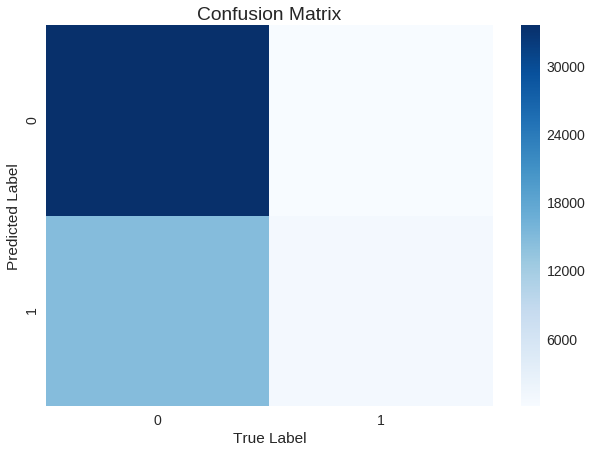

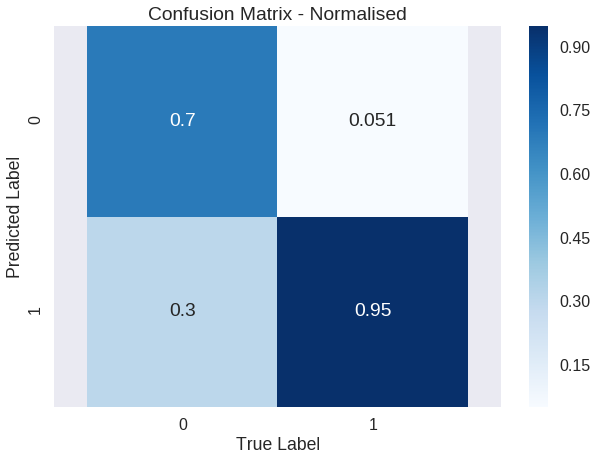

In [175]:
ConfusionMtx_Report2(grid_1w.best_estimator_, X_test, y_test)

In [176]:
feature_importances_rf = pd.DataFrame(grid_1w.best_estimator_.named_steps["model"].feature_importances_,
                                  index = X_train.columns,
                                  columns=['importance']).sort_values('importance',ascending=False)

feature_importances_rf

,importance
last_pymnt_amnt,0.499767
int_rate,0.090867
loan_amnt,0.047092
mo_sin_old_rev_tl_op,0.032930
bc_util,0.031537
bc_open_to_buy,0.030599
revol_util,0.030473
dti,0.029661
annual_inc,0.028355
tot_cur_bal,0.028306


#### Plotting ROC Curve

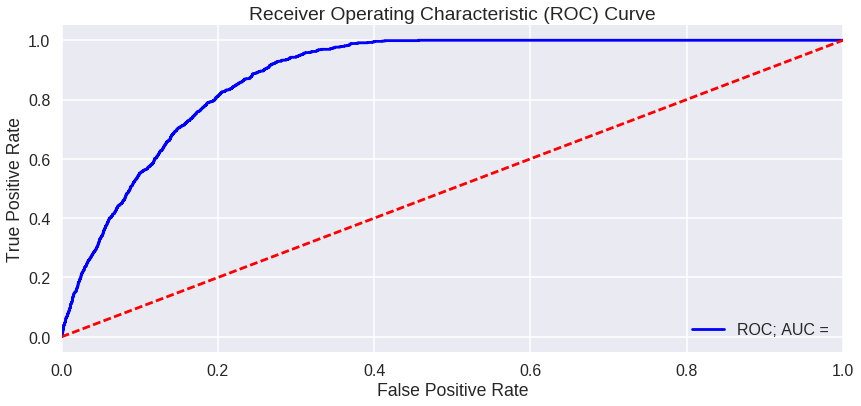

In [177]:
probs = grid_1w.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(14,6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'ROC; AUC =' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XGBoost

In [178]:
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed) # parametr dla losowej cross-validation


weight_scale_pos = np.sum([y_train==0])/y_train.shape[0]*100 # wagi dla klas scale_pos_weight (ratio of negative class to positive)

models = Pipeline([("model",XGBClassifier(objective='binary:logistic',
                                         silent=True,
                                         njobs=2, scale_pos_weight = weight_scale_pos
                                         ))]) # pipeline dla modelu



"""
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
      colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
      max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
      n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
      silent=True, subsample=1)
"""

param_grids = {
    'model__n_estimators':ss.randint(10,300),
    'model__learning_rate':ss.uniform(0.01,0.3),
    #'model_reg_lambda':ss.uniform(0.1,3),
    'model__min_child_weight': ss.randint(5,50),
    'model__gamma': ss.uniform(0.1,3),
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': ss.randint(5,30), 
    #'model__scale_pos_weight': [weight_scale_pos]#, 0.9, 0.7, 0.5]
       } # parametry, które hyper-tuningujemy / optymalizujemy


grid_2w = RandomizedSearchCV(models, param_grids, scoring='roc_auc', n_jobs=-1, cv=kfold, verbose=2)


grid_2w.fit(X_train, y_train)
print(roc_auc_score(grid_2w.best_estimator_.predict(X_val),y_val),
        grid_2w.best_params_) # zwraca najwyzsza srednia "poprawność" modelu i parametryuj

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


0.857540448401213 {'model__colsample_bytree': 0.8, 'model__gamma': 2.2809162886483176, 'model__learning_rate': 0.06711481986600938, 'model__max_depth': 18, 'model__min_child_weight': 14, 'model__n_estimators': 180, 'model__subsample': 1.0}


In [179]:
# # Use pickle to save model for next usage.
# filename4 = 'xgb_m2.2.pk'
# with open('./'+filename4, 'wb') as file:
#     pickle.dump(grid_2w, file)

In [180]:
# Open saved model, and directly make the prediction with new data
with open('./'+filename4 ,'rb') as f:
    grid_2w = pickle.load(f)

In [181]:
y_predw2 = grid_2w.best_estimator_.predict(X_test) # predykcja uzywajac modelu

In [182]:
roc_auc_score(y_test, y_predw2) # auc dla predykcji

0.8176364022324927

In [183]:
classification_report(y_test, y_predw2)

'              precision    recall  f1-score   support\n\n           0       1.00      0.64      0.78     48241\n           1       0.04      1.00      0.09       819\n\n   micro avg       0.64      0.64      0.64     49060\n   macro avg       0.52      0.82      0.43     49060\nweighted avg       0.98      0.64      0.77     49060\n'

In [184]:
f1_score(y_test, y_predw2)

0.08549155025375398

In [185]:
precision_score(y_test, y_predw2)

0.04465945118618126

In [186]:
recall_score(y_test, y_predw2)

0.9975579975579976

In [187]:
mean_squared_error(y_test, y_predw2)

0.3562780269058296

In [188]:
accuracy_score(y_test, y_predw2)

0.6437219730941705

-------------------
Number of 'true' values in each class:
0 48241
1 819
-------------------
Confusion Matrix:
[[30764     2]
 [17477   817]]
-------------------


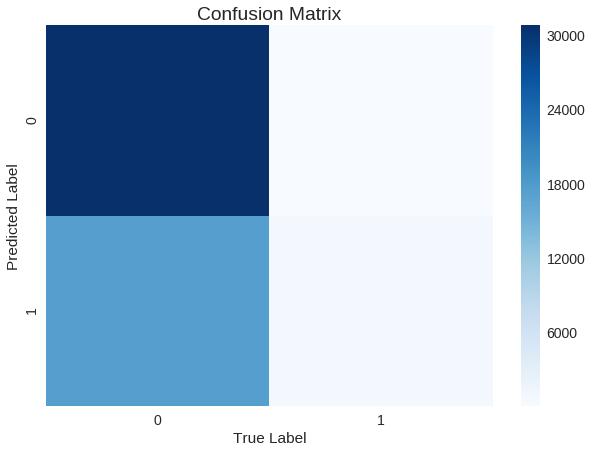

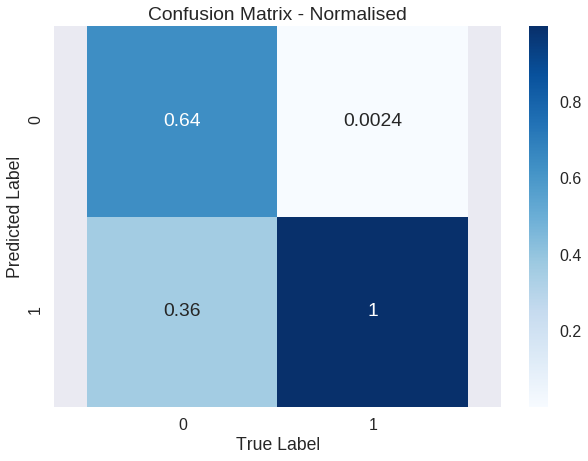

In [189]:
ConfusionMtx_Report2(grid_2w.best_estimator_, X_test, y_test)

In [190]:
feature_importances_xgb = pd.DataFrame(grid_2w.best_estimator_.named_steps["model"].feature_importances_,
                                  index = X_train.columns,
                                  columns=['importance']).sort_values('importance',ascending=False)

feature_importances_xgb

,importance
int_rate,0.166192
last_pymnt_amnt,0.096833
loan_amnt,0.070736
dti,0.063148
mo_sin_old_rev_tl_op,0.062506
annual_inc,0.058743
tot_cur_bal,0.058039
bc_open_to_buy,0.057702
revol_util,0.053327
mo_sin_old_il_acct,0.052899


#### Plotting ROC Curve

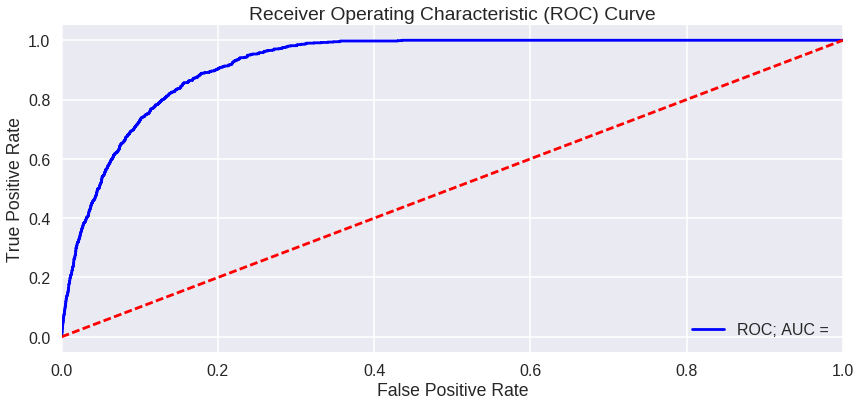

In [191]:
probs = grid_2w.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(14,6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'ROC; AUC =' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# SUMMARY

The best results out of the two models were obtained using the XGBoost Model (ROC of nearly 82%). What is particularly satisfying is the high recall score (almost 100%!) meaning that almost 100% defaults from a previously unseen test set were detected correctly. The random forest model has a slightly higher ROC (more than 82%%) but at the expense of the Recall (95%). It depends on the exact aim of the detection analysis, ie if we rather want to focus on overall accuracy or detect bad loans as accurately as possible.

This is particularly good as the test set was bigger than the training set, meaning the undersampling technique and drastically decreasing the number of training observations is a good representation of the modelled "population" and enough to make inference.

Although intuitive, it is also interesting to see the highest impact on probability of default has the interest rate. This is very plausible, because unlike loan_amount which is somehow limited and "adjusted" to the client depending on their earnings, worth and credibility, the interest rata represents the proportion of the client's loan amount and so the higher it is, the more difficult it is for a customer to make repayments at their set earnings / worth level.

It could be a good idea to test the set with more training data and using weights / penalise the model as opposed to undersampling, hence this could also be a point to consider in the future when further developing this project.

It would be interesting to see if we can obtain better results using other available machine and deep learning techniques such as Neural Networks or GBM and LightGBM. It would also be interesting to compare the results to traditional statistical methods such as gradually built logistic regression, although the number of features is probably too large to do this task "manually"
and so machine learning approach is neccessary.